<a href="https://colab.research.google.com/github/leonardoLavagna/TCGA-PRAD/blob/main/PRAD_hub_genes_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Prostate Adenocarcinoma (PRAD) hub genes



## Installation of the required packages, libreries and set up
#### Installation of required packages

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

In [ ]:
BiocManager::install("TCGAbiolinks")

In [ ]:
BiocManager::install("SummarizedExperiment")

In [ ]:
BiocManager::install("DESeq2")

In [ ]:
BiocManager::install("netDx")

In [ ]:
install.packages('htmltools',force=True)

In [ ]:
BiocManager::install("WGCNA",force = TRUE)

In [ ]:
BiocManager::install("netbiov")

In [ ]:
install.packages("igraph")

In [ ]:
install.packages("cowplot")

In [ ]:
install.packages("psych")

In [ ]:
install.packages("vegan")

#### Required libraries

In [ ]:
# Library to handle DEGs

library(DESeq2)

In [ ]:
# Libraries for merging and cleaning the data

library(dplyr)
library(stringr)

In [15]:
# Libraries for data extraction

library(TCGAbiolinks)
library(SummarizedExperiment)

In [ ]:
# Libraries for plotting

library(cowplot)
library(tidyverse)
library(igraph)
library(netbiov)

In [ ]:
# Library for communities' extraction

library(vegan)

In [ ]:
# Libraries for correlation networks

library(psych)      
library(WGCNA)

#### Directory tree setup

In [ ]:
proj <- "TCGA-PRAD"
dir.create(file.path(proj))

## PART I
## DATA 

### I.1 Getting the Data 
For references, see https://portal.gdc.cancer.gov/projects/TCGA-PRAD.

In [ ]:
# Extract primary tumor data

rna.query.C <- GDCquery(project = proj, data.category = "Transcriptome Profiling", data.type = "Gene Expression Quantification", workflow.type = "STAR - Counts", sample.type = "Primary Tumor") 
GDCdownload(query = rna.query.C, directory = "GDCdata", method = "api")
rna.data.C <- GDCprepare(rna.query.C)
rna.expr.data.C <- assay(rna.data.C)
rna.genes.info.C <- rowRanges(rna.data.C)
rna.sample.info.C <- colData(rna.data.C)
write.table(rna.expr.data.C, file=file.path(proj,paste(proj, "_rna_expr_data_C.txt",sep = "")), row.names=TRUE, col.names=TRUE, quote = FALSE)
write.table(rna.sample.info.C@listData$patient, file=file.path(proj,paste(proj, "_rna_patients_C.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)
write.table(rna.genes.info.C@ranges@NAMES, file=file.path(proj,paste(proj, "_rna_genes_C.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)


In [ ]:
# Extract solid tissue normal data

rna.query.N <- GDCquery(project = proj, data.category = "Transcriptome Profiling", data.type = "Gene Expression Quantification", workflow.type = "STAR - Counts", sample.type = "Solid Tissue Normal") 
GDCdownload(query = rna.query.N, directory = "GDCdata", method = "api")
rna.data.N <- GDCprepare(rna.query.N)
rna.expr.data.N <- assay(rna.data.N)
rna.genes.info.N <- rowRanges(rna.data.N)
rna.sample.info.N <- colData(rna.data.N)
write.table(rna.expr.data.N, file=file.path(proj,paste(proj, "_rna_expr_data_N.txt",sep="")), row.names=TRUE, col.names=TRUE, quote = FALSE)
write.table(rna.sample.info.N@listData$patient, file=file.path(proj,paste(proj, "_rna_patients_N.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)
write.table(rna.genes.info.N@ranges@NAMES, file=file.path(proj,paste(proj, "_rna_genes_N.txt",sep = "")), row.names=FALSE, col.names=FALSE, quote = FALSE)


### I.2 Processing the extracted data

#### 1) read the condition (tumor) TCGA-PRAD dataset

In [22]:
# Get genomic data

rna_expr_data_C <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_expr_data_C.txt", header=TRUE, sep="", check.names = F) 

In [23]:
# Check
# A data.frame: 60660 (genes) × 501 (patients)

#View(rna_expr_data_C)

In [24]:
# Extract first column with the genes

rna_gene_data_C <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_genes_C.txt", header=FALSE, sep="", check.names = F) 

In [25]:
# Check
# A data.frame: 60660 × 1

#View(rna_gene_data_C)

In [26]:
# Get patient's data

rna_patients_data_C <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_patients_C.txt", header=FALSE, sep="", check.names = F) 

In [27]:
# Check
# A data.frame: 501

#View(rna_patients_data_C)

#### 2) read the normal (without tumor) TCGA-PRAD dataset

In [28]:
# Get genomic data

rna_expr_data_N <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_expr_data_N.txt", header=TRUE, sep="", check.names = F) 

In [29]:
# Check
# A data.frame: 60660 (genes) × 52 (patients)

# View(rna_expr_data_N)

In [30]:
# Extract first column with the genes

rna_gene_data_N <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_genes_N.txt", header=FALSE, sep="", check.names = F) 

In [31]:
# Check
# A data.frame: 60660 × 1

#View(rna_gene_data_N)

In [32]:
# Get patient's data

rna_patients_data_N <- read.table("./TCGA-PRAD/TCGA-PRAD_rna_patients_N.txt", header=FALSE, sep="", check.names = F) 

In [33]:
# Check
# A data.frame: 52 × 1

#View(rna_patients_data_N)

#### 3) read patient's clinical data that could be useful for later analysis

In [34]:
clinical.query<-GDCquery_clinic(project = proj, type = "clinical", save.csv = FALSE)
write.csv(clinical.query, file = file.path(proj,paste(proj, "_clinical_data.txt",sep="")), row.names = FALSE, quote = FALSE)

In [35]:
clinical_data <- read.csv2("./TCGA-PRAD/TCGA-PRAD_clinical_data.txt", header = FALSE, sep=",")
colnames(clinical_data) <- clinical_data[1,]; clinical_data <- clinical_data[-1,] 
#View(clinical_data)

#### 4) Intersection and cleaning of partecipants' data

In [36]:
# merge common patients

common_patients <- merge(rna_patients_data_C, rna_patients_data_N, by.x="V1", by.y="V1")

In [37]:
# subtract useless column between the two expression data.frames using a boolean mask
# check for multiple patterns and use the boolean mask created to filter through the columns

mask_tuned_patientsC <- str_detect(as.vector(colnames(rna_expr_data_C)), paste(as.vector(unlist(common_patients)), collapse = '|'))
rna_expr_data_C <- rna_expr_data_C[, mask_tuned_patientsC]

mask_tuned_patientsN <- str_detect(as.vector(colnames(rna_expr_data_N)), paste(as.vector(unlist(common_patients)), collapse = '|')) 
rna_expr_data_N <- rna_expr_data_N[, mask_tuned_patientsN] 

In [38]:
# cleaning the rows with any zero values through each of the two dataframes

rna_expr_data_C <- rna_expr_data_C[apply(rna_expr_data_C, 1, function(x) all(x!=0)),]
rna_expr_data_N <- rna_expr_data_N[apply(rna_expr_data_N, 1, function(x) all(x!=0)),]


In [39]:
# row-wise intersection (genes) of the two dataframes

rna_expr_data_C <- subset(rna_expr_data_C, rownames(rna_expr_data_C) %in% rownames(rna_expr_data_N))
rna_expr_data_N <- subset(rna_expr_data_N, rownames(rna_expr_data_N) %in% rownames(rna_expr_data_C))


In [40]:
# Verify that all the duplicate partecipants have been removed

# dummy_split <- as.data.frame(t(apply(common_patients, 1, function(k){
# sym <- unlist(strsplit(k, split = "-"))
# return(c(sym[1], sym[2], sym[3]))
# }))); colnames(dummy_split) <- c("A", "B", "C"); dummy_split[duplicated(dummy_split$C),]


In [41]:
# Final Check

View(rna_expr_data_C)

TCGA-EJ-7786-01A-11R-2118-07 TCGA-G9-6365-01A-11R-1789-07
ENSG00000000003.15  3110                         5468                       
ENSG00000000419.13  1450                         1701                       
ENSG00000000457.14   956                         1154                       
ENSG00000000460.17   184                          186                       
ENSG00000000938.13   249                          281                       
ENSG00000000971.16  2057                         2125                       
ENSG00000001036.14  2141                         3536                       
ENSG00000001084.13  3006                         1986                       
ENSG00000001167.14  1587                         1706                       
ENSG00000001460.18  1035                          758                       
ENSG00000001461.17 25620                         2045                       
ENSG00000001497.18  2374                         3209                       
ENSG00000001561.7   4256                         2198                       
ENSG00000001617.12  4532                         4233                       
ENSG00000001626.16    75                          971                       
ENSG00000001629.10  3809                         3223                       
ENSG00000001630.17   295                           40                       
ENSG00000001631.16   260                          330                       
ENSG00000002016.18   546                          376                       
ENSG00000002330.14   677                          882                       
ENSG00000002549.12  5057                         4707                       
ENSG00000002586.20 13673                        17212                       
ENSG00000002587.10   236                          303                       
ENSG00000002726.21    46                           39                       
ENSG00000002746.15   113                          189                       
ENSG00000002834.18  4370                         5630                       
ENSG00000002919.15  1372                         1349                       
ENSG00000002933.9    250                         2088                       
ENSG00000003056.8   3106                         2263                       
ENSG00000003096.14   441                          781                       
⋮                  ⋮                            ⋮                           
ENSG00000287886.1   12                           47                         
ENSG00000287906.1  451                          449                         
ENSG00000287917.1   18                           33                         
ENSG00000287960.1   10                           15                         
ENSG00000287966.1   45                          188                         
ENSG00000287975.1   39                            9                         
ENSG00000287985.1   60                            7                         
ENSG00000287998.1   15                           13                         
ENSG00000288009.1  234                           52                         
ENSG00000288045.1   33                           27                         
ENSG00000288046.1  101                           62                         
ENSG00000288066.1  694                          953                         
ENSG00000288075.1   61                          146                         
ENSG00000288093.1   24                           24                         
ENSG00000288095.1   26                           14                         
ENSG00000288096.1   50                          125                         
ENSG00000288156.1   38                           95                         
ENSG00000288162.1    2                            8                         
ENSG00000288398.1  640                          685                         
ENSG00000288538.1   22                            3                         
ENSG00000288547

In [42]:
# Final Check

View(rna_expr_data_N)

TCGA-HC-7745-11A-01R-2118-07 TCGA-G9-6351-11A-01R-1965-07
ENSG00000000003.15  1342                         5623                       
ENSG00000000419.13   951                         1496                       
ENSG00000000457.14   617                          816                       
ENSG00000000460.17   146                          119                       
ENSG00000000938.13   124                          291                       
ENSG00000000971.16  1519                          880                       
ENSG00000001036.14  1675                         2425                       
ENSG00000001084.13  1767                         3661                       
ENSG00000001167.14   743                         1453                       
ENSG00000001460.18   398                         1209                       
ENSG00000001461.17  2165                        24349                       
ENSG00000001497.18  2038                         2427                       
ENSG00000001561.7   5497                         2128                       
ENSG00000001617.12  6240                         3264                       
ENSG00000001626.16    38                          222                       
ENSG00000001629.10  2923                         1978                       
ENSG00000001630.17    75                          105                       
ENSG00000001631.16   237                          232                       
ENSG00000002016.18   372                          435                       
ENSG00000002330.14   596                          638                       
ENSG00000002549.12  2494                         3350                       
ENSG00000002586.20 15449                        20444                       
ENSG00000002587.10   416                          265                       
ENSG00000002726.21    54                         5287                       
ENSG00000002746.15    38                          325                       
ENSG00000002834.18  5558                         4270                       
ENSG00000002919.15   962                         1330                       
ENSG00000002933.9    151                          535                       
ENSG00000003056.8   2723                         2607                       
ENSG00000003096.14  1147                          551                       
⋮                  ⋮                            ⋮                           
ENSG00000287886.1    46                          25                         
ENSG00000287906.1   283                         372                         
ENSG00000287917.1    11                          28                         
ENSG00000287960.1     6                           7                         
ENSG00000287966.1    64                         115                         
ENSG00000287975.1     4                          76                         
ENSG00000287985.1    27                          14                         
ENSG00000287998.1    25                          27                         
ENSG00000288009.1    15                         165                         
ENSG00000288045.1    13                          32                         
ENSG00000288046.1     7                          94                         
ENSG00000288066.1   440                         780                         
ENSG00000288075.1    91                         952                         
ENSG00000288093.1    24                          17                         
ENSG00000288095.1    16                          20                         
ENSG00000288096.1     5                          74                         
ENSG00000288156.1    18                          42                         
ENSG00000288162.1    15                          24                         
ENSG00000288398.1   675                         515                         
ENSG00000288538.1    17                          11                         
ENSG00000288547

## PART II
## Differentially Expressed Genes (DEGs)

### II.2 Processing 

#### 1) Merging of the columns

In [43]:
# sort the column names for each dataset before merging them

rna_expr_data_C <- rna_expr_data_C[,order(colnames(rna_expr_data_C))]
rna_expr_data_N <- rna_expr_data_N[,order(colnames(rna_expr_data_N))]

In [44]:
# Rename the columns

addInfoData <- function(dt, info){
  colInfo <- c()

  for(name in colnames(dt)){
    colInfo <- c(colInfo, paste(name, info, sep=""))  
  }
  
  colnames(dt) <- colInfo
  return(dt)
}

rna_expr_data_C <- addInfoData(rna_expr_data_C, "_tumor")
rna_expr_data_N <- addInfoData(rna_expr_data_N, "_normal")


In [45]:
# Merge the columns, sorted and aggregated

full_dt <- cbind(rna_expr_data_N, rna_expr_data_C) 


In [46]:
# Check
# A data.frame: 18271 × 106

#View(full_dt)

#### 2) Additional informations

In [47]:
# create a dataset with additional information

PartecipantsCondition <- data.frame(partecipants = colnames(full_dt),
                                    condition = NA) 
PartecipantsCondition <- as.data.frame(t(apply(PartecipantsCondition, 1, function(x){
    if(grepl("tumor", x["partecipants"]))
      return(c(x["partecipants"], condition = "tumor"))
    else
      return(c(x["partecipants"], condition = "normal"))
})));

In [48]:
# creating the Object of our merged matrix to be "DESQued"

DESQ_dt <- DESeqDataSetFromMatrix(countData = full_dt,
                                  colData = PartecipantsCondition,
                                  design= ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


#### 3) Remove the genes where there are very few reads
*Remark:* This processing step will reduce the memory size of the actual dataset, and increase also the future transformation and testing functions.

In [49]:
# Here we perform a minimal pre-filtering to keep only rows that have at least 10 reads total. 
# Note that more strict filtering to increase power is automatically applied via 
# independent filtering on the mean of normalized counts within the results function.

# 10 here is a first crass threshold... more strict less genes
keep <- rowSums(counts(DESQ_dt)) >= 10 
DESQ_dt <- DESQ_dt[keep,]

#### 4) Tresholding
*Remark:* here we get the results, obtaining the correction FDR through different tests Its important to keep track of the adjpvalue

In [ ]:
DESQ_dtOutput <- DESeq(DESQ_dt)

In [51]:
# this applies a threshold of alpha = 0.05, to make correction of different tests applied, 
# we apply some corrections optimizing the number of genes which will have an adjusted p value below a given FDR cutoff, 
# alpha = 0.05 

res <- results(DESQ_dtOutput, alpha = 0.05, lfcThreshold = 1.2)  

*Remark:* LFC means Log Fold Change. Recall that if LFC > 0 then the number of genes is up-regulated and viceversa (down-regulated < 0).  Moreover LFC > 0 means more expression in NORMAL condition, and LFC < 0  menas is more expression in TUMOR condition.



In [52]:
# Display the summary of the results

summary(res)


out of 18271 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.20 (up)    : 49, 0.27%
LFC < -1.20 (down) : 120, 0.66%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



#### 4) Plots

In [53]:
# differentially expressed gene ordered from the lower at the larger value of adjustedPvalue

resOrdered <- res[order(res$padj), ]

In [54]:
# versus conditions

resultsNames(DESQ_dtOutput)

[1] "Intercept"                 "condition_tumor_vs_normal"

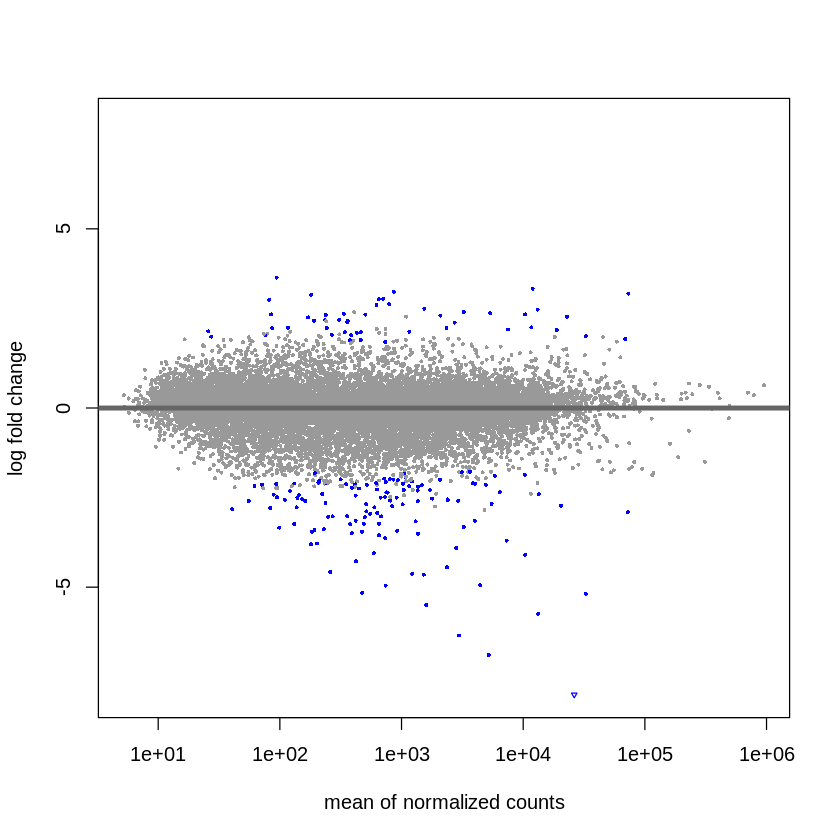

In [55]:
# the function plotMA shows the log2 fold changes attributable to a given variable 
# over the mean of normalized counts for all the samples in the DESeqDataSet. 
# Points will be colored red if the adjusted p value is less than 0.1. 
# Points which fall out of the window are plotted as open triangles pointing either up or down.
 
plotMA(res, ylim = c(-8, 8))

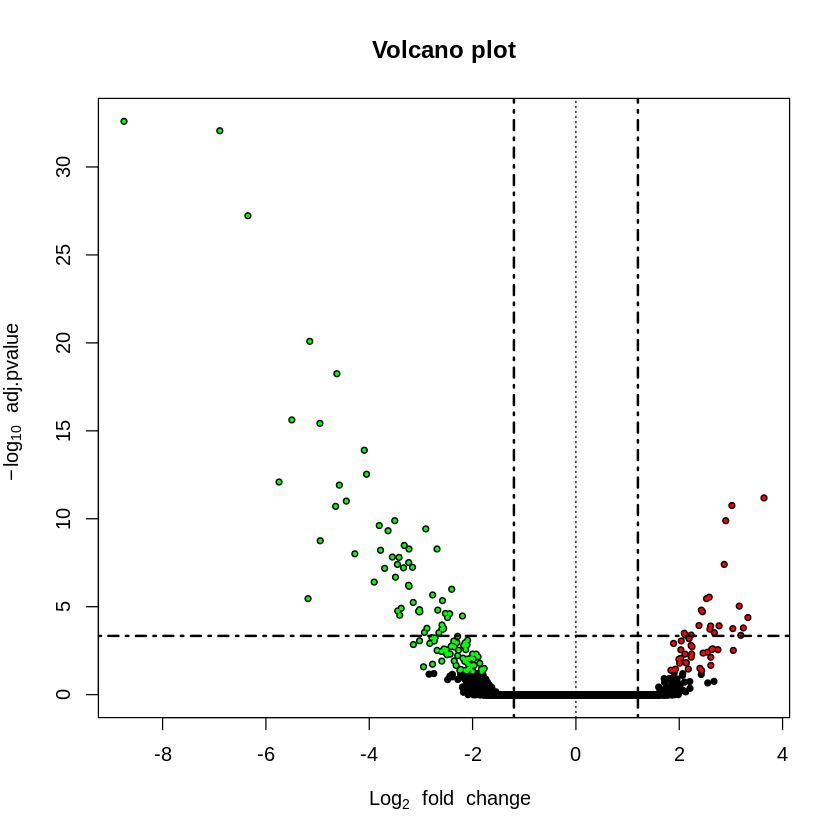

In [56]:
# Volcano Plot
# See https://en.wikipedia.org/wiki/Fold_change

topT <- as.data.frame(res)

#Adjusted P values (FDR Q values)
with(topT, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", cex=1.0, xlab=bquote(~Log[2]~fold~change), ylab=bquote(~-log[10]~adj.pvalue)))
with(subset(topT, padj<=0.05 & log2FoldChange>=1.2), points(log2FoldChange, -log10(padj), pch=20, col="red", cex=0.5))
with(subset(topT, padj<=0.05 & log2FoldChange<= -1.2), points(log2FoldChange, -log10(padj), pch=20, col="green", cex=0.5))

#Add lines 
abline(v=0, col="black", lty=3, lwd=1.0)
abline(v=-1.2, col="black", lty=4, lwd=2.0)
abline(v=1.2, col="black", lty=4, lwd=2.0)
abline(h=-log10(max(topT$pvalue[topT$padj<=0.05], na.rm=TRUE)), col="black", lty=4, lwd=2.0)


## PART III
## Co-expression networks

### III.1 Extract the relevant data from the differentially expressed ordered gene seen in II.2

In [57]:
# extract the filtered DEGs

res_save <- subset(resOrdered, padj <= 0.05)
final_dt <- as.data.frame(res_save)

In [58]:
# extract the genes 

genes_passed <- rownames(final_dt)

In [59]:
# Check

View(final_dt)

baseMean    log2FoldChange lfcSE     stat       pvalue      
ENSG00000159763.4  26270.48322 -8.746855      0.5890066 -12.812854 1.389291e-37
ENSG00000188488.14  5222.81159 -6.892346      0.4495320 -12.662827 9.501553e-37
ENSG00000168389.18  2954.25041 -6.348634      0.4391845 -11.723170 9.697377e-32
ENSG00000101977.21   475.74124 -5.152180      0.3870854 -10.210097 1.786856e-24
ENSG00000095713.14  1222.67934 -4.626494      0.3508094  -9.767395 1.553957e-22
ENSG00000229847.9   1599.88908 -5.498198      0.4715642  -9.114767 7.883975e-20
ENSG00000164398.15   740.69224 -4.955070      0.4149645  -9.049135 1.441053e-19
ENSG00000085662.14 10385.47783 -4.096549      0.3351993  -8.641274 5.558966e-18
ENSG00000197705.10   590.91606 -4.052591      0.3453054  -8.261065 1.443788e-16
ENSG00000186526.13 13273.20345 -5.746262      0.5594736  -8.125963 4.438227e-16
ENSG00000158955.11   259.68979 -4.578954      0.4189701  -8.064905 7.329311e-16
ENSG00000164175.15    94.14362  3.640472      0.3110439   7.846070 4.292776e-15
ENSG00000141750.7   2363.03237 -4.443797      0.4167164  -7.784184 7.016458e-15
ENSG00000227392.2     81.54118  3.018884      0.2361778   7.701333 1.346545e-14
ENSG00000104267.10  1520.36957 -4.650439      0.4493987  -7.677901 1.617161e-14
ENSG00000103034.14  1366.62194 -3.505805      0.3106209  -7.423211 1.143147e-13
ENSG00000242110.8    791.15912  2.899901      0.2291894   7.417014 1.197904e-13
ENSG00000163364.10   179.78282 -3.806588      0.3558182  -7.325618 2.378003e-13
ENSG00000120885.22 72647.65982 -2.905137      0.2349149  -7.258528 3.913241e-13
ENSG00000270885.2    734.14093 -3.636225      0.3374827  -7.218814 5.244294e-13
ENSG00000091138.13  4445.17992 -4.948518      0.5330998  -7.031550 2.042522e-12
ENSG00000159251.8   3249.65054 -3.323028      0.3059137  -6.939956 3.922207e-12
ENSG00000103485.19  1018.95367 -2.688366      0.2167354  -6.867204 6.547219e-12
ENSG00000132639.13   652.76290 -3.230896      0.2960234  -6.860592 6.857558e-12
ENSG00000152779.14   202.86814 -3.781283      0.3778809  -6.830944 8.435792e-12
ENSG00000170689.10   421.85059 -4.279029      0.4556056  -6.758102 1.398113e-11
ENSG00000143632.14   652.39292 -3.552943      0.3516649  -6.690867 2.218516e-11
ENSG00000104879.5    921.65083 -3.423554      0.3329115  -6.679115 2.403901e-11
ENSG00000134042.14   131.49858 -3.235999      0.3097210  -6.573655 4.909500e-11
ENSG00000187122.17   622.32571  2.870573      0.2557149   6.532948 6.448741e-11
⋮                  ⋮           ⋮              ⋮         ⋮          ⋮           
ENSG00000245750.10  1162.29757  2.127579      0.2405666  3.855810  0.0001153471
ENSG00000246228.6     25.80154  2.136563      0.2437015  3.843076  0.0001215018
ENSG00000125257.16 32757.32421  2.008143      0.2107015  3.835490  0.0001253144
ENSG00000152137.8  10286.80835 -1.860382      0.1725229 -3.827792  0.0001292978
ENSG00000159337.7    598.63147 -2.774587      0.4146161 -3.797700  0.0001460448
ENSG00000172005.11   207.28983 -2.083456      0.2330578 -3.790716  0.0001502136
ENSG00000148600.15   211.44020 -2.038124      0.2234629 -3.750619  0.0001763989
ENSG00000160180.15 10387.20239  2.611251      0.3762313  3.751020  0.0001761163
ENSG00000187699.10   722.03266 -1.970001      0.2050953 -3.754359  0.0001737857
ENSG00000263961.8    121.19955 -2.318673      0.2981110 -3.752539  0.0001750529
ENSG00000122756.15   315.36656 -1.991697      0.2112251 -3.748119  0.0001781654
ENSG00000164879.7    554.09891 -2.950048      0.4729330 -3.700413  0.0002152489
ENSG00000273179.1    358.95511  2.399940      0.3289894  3.647350  0.0002649585
ENSG00000117266.16  1215.75371 -2.049667      0.2332388 -3.642903  0.0002695801
ENSG00000244509.4   3649.88921 -1.776065      0.1583478 -3.637975  0.0002747905
ENSG00000174611.12   240.61181 -2.083113      0.2441908 -3.616487  0.0002986287
ENSG00000211689.7  18839.67570  2.175602      0.2696793  3.617636  0.0002973056
ENSG00000163110.15 69214.65409  1.927213      0.2013632  3.611452  0.0003044877
ENSG00000181234.9  

### III.2 Processing

In [60]:
# filter the two datasets expressed in tumor and normal 

rna_expr_data_C <- rna_expr_data_C[genes_passed, ]
rna_expr_data_N <- rna_expr_data_N[genes_passed, ]

In [61]:
# create the correlation datasets for plotting the network for each graph

co_net_corr_dataC <- cor(t(rna_expr_data_C), method = "pearson")
co_net_corr_dataN <- cor(t(rna_expr_data_N), method = "pearson")

In [62]:
# log-transform FPKM data using log2(x+1) of each count
# See https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/

rna_expr_data_C <- log2(rna_expr_data_C+1)
rna_expr_data_N <- log2(rna_expr_data_N+1)

### III.3 Plots and Trasholding

In [63]:
distroRho_pearsC <- co_net_corr_dataC[upper.tri(co_net_corr_dataC)]
distroRho_pearsN <- co_net_corr_dataN[upper.tri(co_net_corr_dataN)]

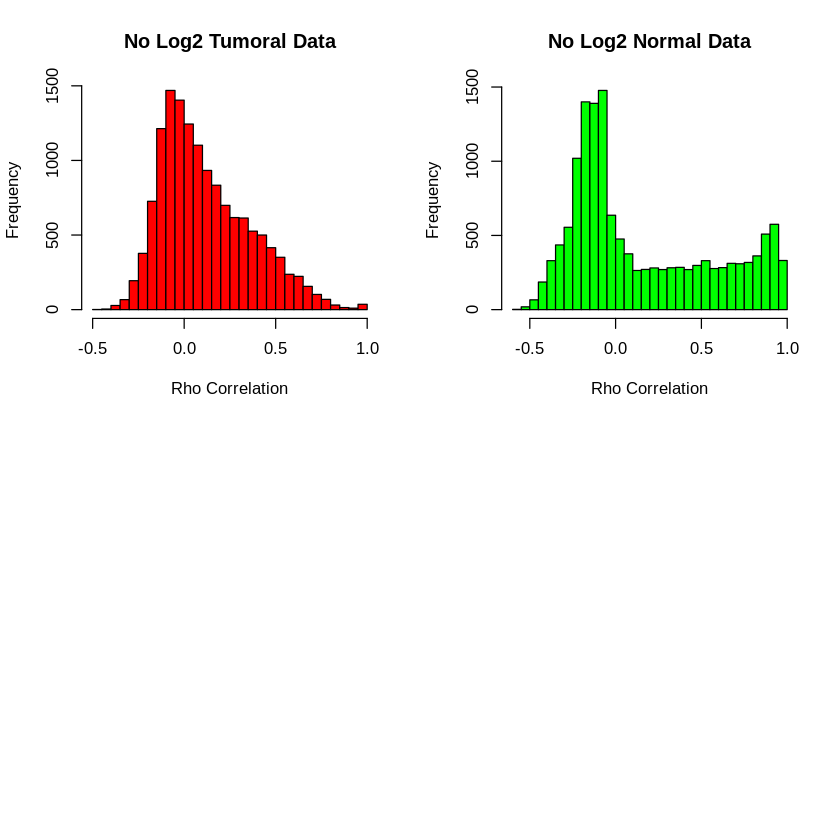

In [64]:
# plot the distribution of the correlations to naively choose a good trashold 

par(mfrow = c(2, 2))
hist(distroRho_pearsC, main = "No Log2 Tumoral Data", col = "red", xlab = "Rho Correlation", breaks = 50)
# x=0.5 to change accordingly 
#points(x = 0.5, y = 0.0, pch = 20, col = "black", cex = 2) 
hist(distroRho_pearsN, main = "No Log2 Normal Data", col = "green", xlab = "Rho Correlation", breaks = 50)
# x=0.5 to change accordingly 
#points(x = 0.5, y = 0.0, pch = 20, col = "black", cex = 2) 

In [65]:
# These are probably the threshold candidates 

#quantile(abs(distroRho_pearsC))
#quantile(abs(distroRho_pearsN))

### III.4 Fine tuned trasholding

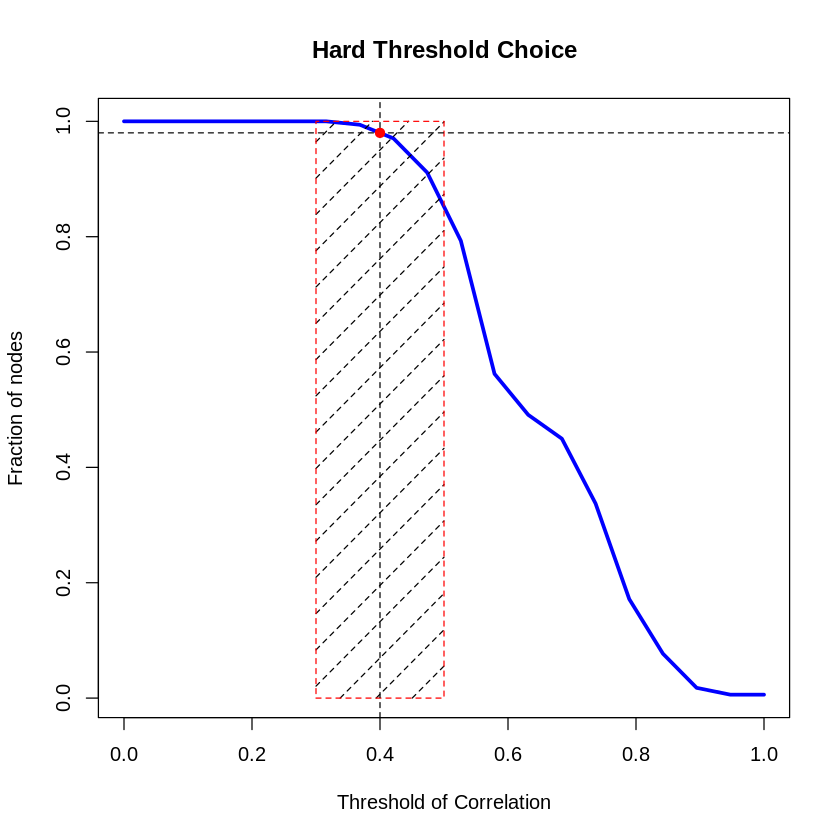

In [66]:
# Find a good threshold 
# Emulate Fiscon lecture (see materials of last year)
# https://classroom.google.com/c/Mjg4MDY4MjkxNDMw

fractionNodes <- function(graph){
  v_graph <- length(V(graph))
  component <- components(graph)
  ind <- which(component$membership == which.max(component$csize))
  LCC <- induced_subgraph(graph , V(graph)[ind])
  v_LCC <- length(V(LCC))
  
  frac_node_LCC <- v_LCC / v_graph
  return(frac_node_LCC)
}

OptimalThresholding <- function(dt, dt2, x){
  # create the correlation datasets for plotting the network for each graph
  co_net_corr_dataC <- cor(t(dt), method = "spearman")
  co_net_corr_dataN <- cor(t(dt2), method = "spearman")
  
  tsh <- x
  co_net_corr_dataC <- ifelse(co_net_corr_dataC <= -abs(tsh) | co_net_corr_dataC >= abs(tsh), 1, 0)
  co_net_corr_dataN <- ifelse(co_net_corr_dataN <= -abs(tsh) | co_net_corr_dataN >= abs(tsh), 1, 0)
  
  gC <- graph_from_adjacency_matrix(co_net_corr_dataC, diag = FALSE)
  gN <- graph_from_adjacency_matrix(co_net_corr_dataN, diag = FALSE)
  
  fracNodes_C <- fractionNodes(gC)
  fracNodes_N <- fractionNodes(gN)
  
  return(mean(fracNodes_C, fracNodes_N))
}

possibletsh <- seq(0, 1, length.out = 20)
densities <- unlist(lapply(possibletsh, function(x){
  return(OptimalThresholding(rna_expr_data_C, rna_expr_data_N, x))
}))

plot(possibletsh, densities, col = "blue", type = "l", lwd = 3, xlab = "Threshold of Correlation", ylab = "Fraction of nodes", main = "Hard Threshold Choice")
rect(xleft = 0.3, ybottom = 0.0, xright = 0.5, ytop = 1.0, density = 5, border = "red", lty = 2, lwd = 1)


abline(h = 0.98, lty=2)
abline(v = 0.4, lty=2)
# this is our preferable naive-hard thresholding
points(x = 0.4, y = 0.98, pch = 20, col = "red", cex = 1.5) 


### III.5 Hubs of genes

### 1) Graph creation and plots

In [67]:
# binary masks

tsh <- 0.6 
co_net_corrBinary_dataC <- ifelse(co_net_corr_dataC <= -abs(tsh) | co_net_corr_dataC >= abs(tsh), 1, 0)
co_net_corrBinary_dataN <- ifelse(co_net_corr_dataN <= -abs(tsh) | co_net_corr_dataN >= abs(tsh), 1, 0)

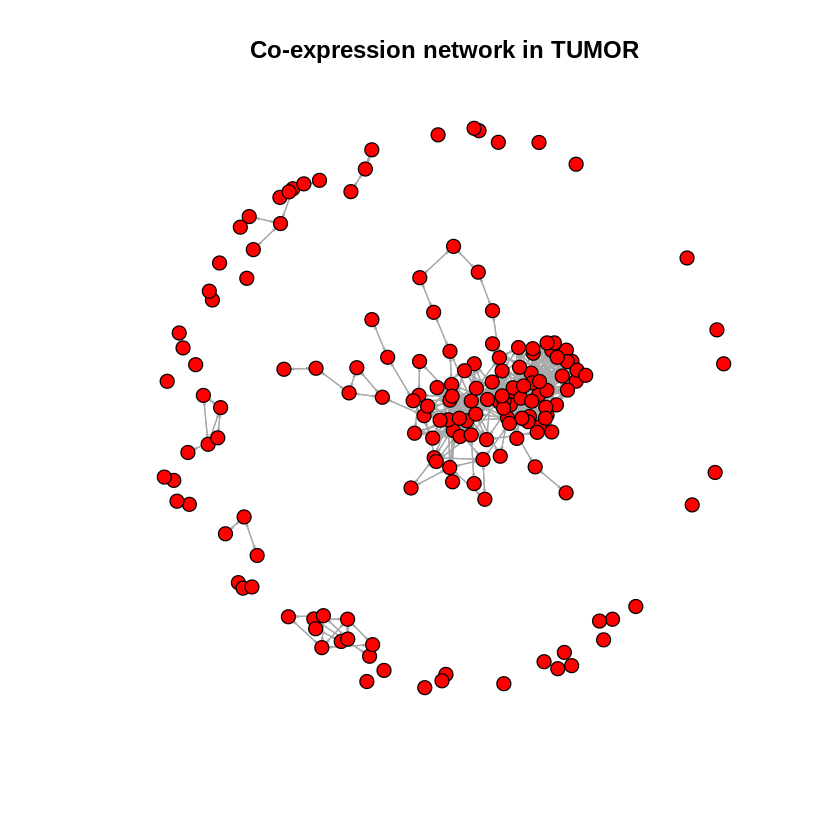

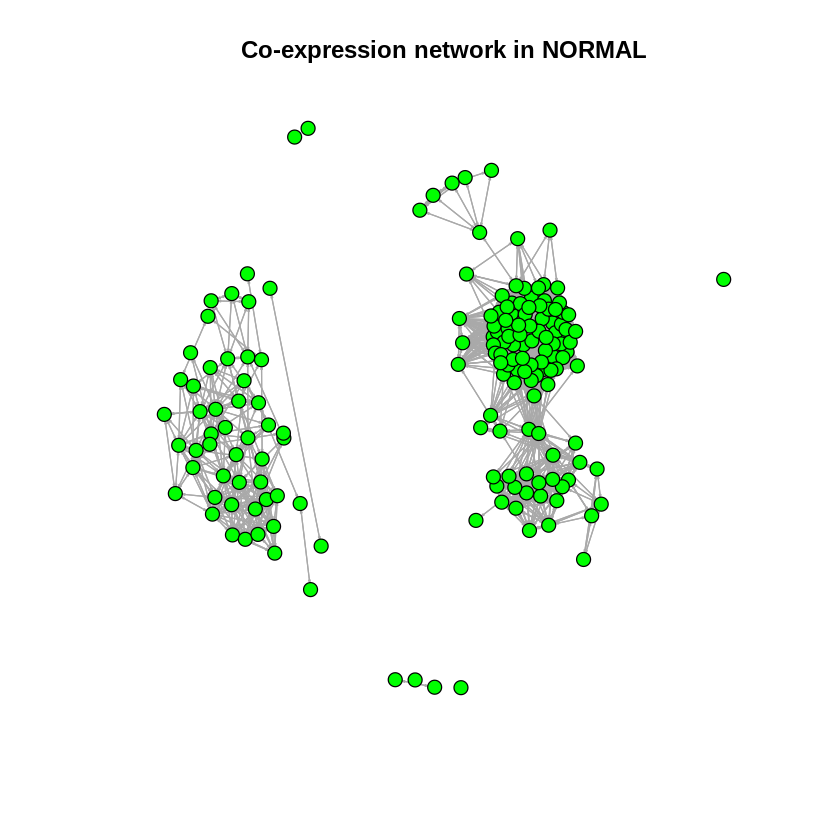

In [68]:
# create the graph

par(mfrow=c(1,1))
gC <- graph_from_adjacency_matrix(co_net_corrBinary_dataC, diag = FALSE)
plot(gC, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "red", main = "Co-expression network in TUMOR",
     arrow.width=.1, edge.arrow.size=.1, layout= layout.kamada.kawai, vertex.label = NA) 


gN <- graph_from_adjacency_matrix( co_net_corrBinary_dataN, diag = FALSE)
plot(gN, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "green", main = "Co-expression network in NORMAL",
     arrow.width=.1, edge.arrow.size=.1, layout= layout.kamada.kawai, vertex.label = NA) 


In [69]:
# Repeat with lower tsh

tsh <- 0.4
co_net_corrBinary_dataC <- ifelse(co_net_corr_dataC <= -abs(tsh) | co_net_corr_dataC >= abs(tsh), 1, 0)
co_net_corrBinary_dataN <- ifelse(co_net_corr_dataN <= -abs(tsh) | co_net_corr_dataN >= abs(tsh), 1, 0)

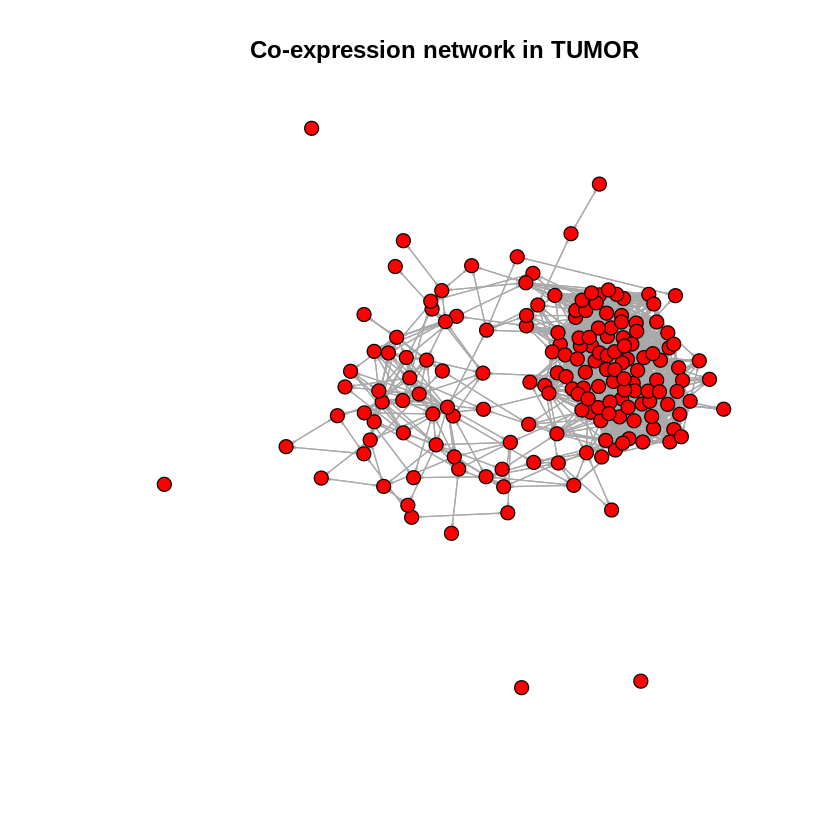

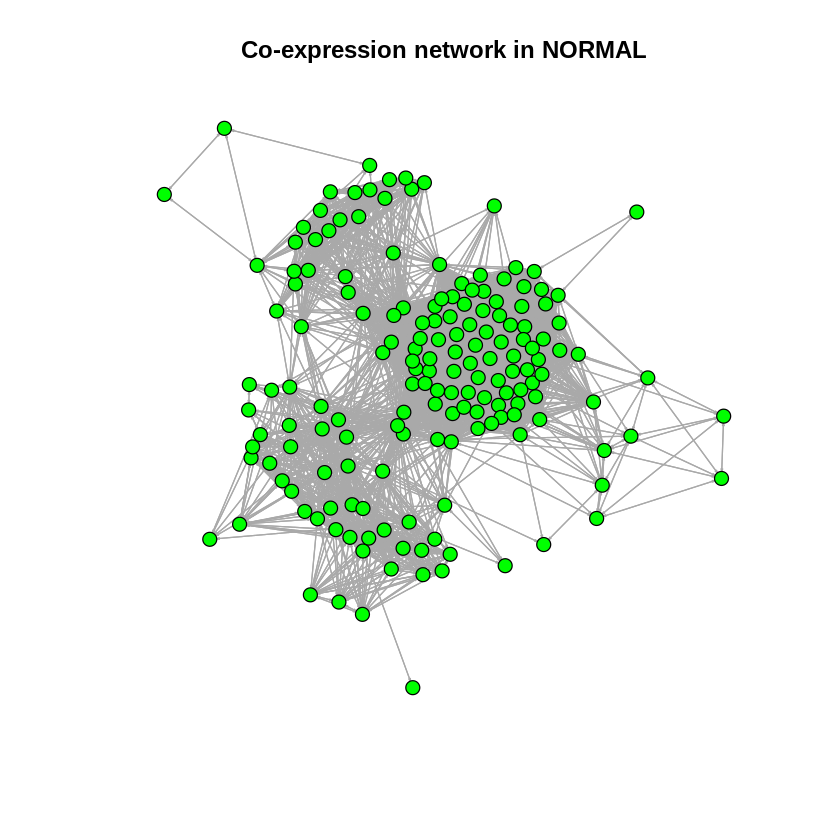

In [70]:
par(mfrow=c(1,1))
gC <- graph_from_adjacency_matrix(co_net_corrBinary_dataC, diag = FALSE)
plot(gC, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "red", main = "Co-expression network in TUMOR",
     arrow.width=.1, edge.arrow.size=.1, layout= layout.kamada.kawai, vertex.label = NA) 


gN <- graph_from_adjacency_matrix( co_net_corrBinary_dataN, diag = FALSE)
plot(gN, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "green", main = "Co-expression network in NORMAL",
     arrow.width=.1, edge.arrow.size=.1, layout= layout.kamada.kawai, vertex.label = NA) 

### 2) Find the Hubs and plots

In [71]:
# degree distribution of the graphs, extract the 5% of HUBS, in their conditions

par(mfrow=c(1,2))
dgC <- degree(gC)
dgN <- degree(gN)
hubs_C <- sort(degree(gC, v = V(gC), mode = "all"), decreasing = TRUE) 
hubs_C <- hubs_C[1:floor(0.05 * length(hubs_C))] 
hubs_N <- sort(degree(gN, v = V(gN), mode = "all"), decreasing = TRUE)
hubs_N <- hubs_N[1:floor(0.05 * length(hubs_N))] 

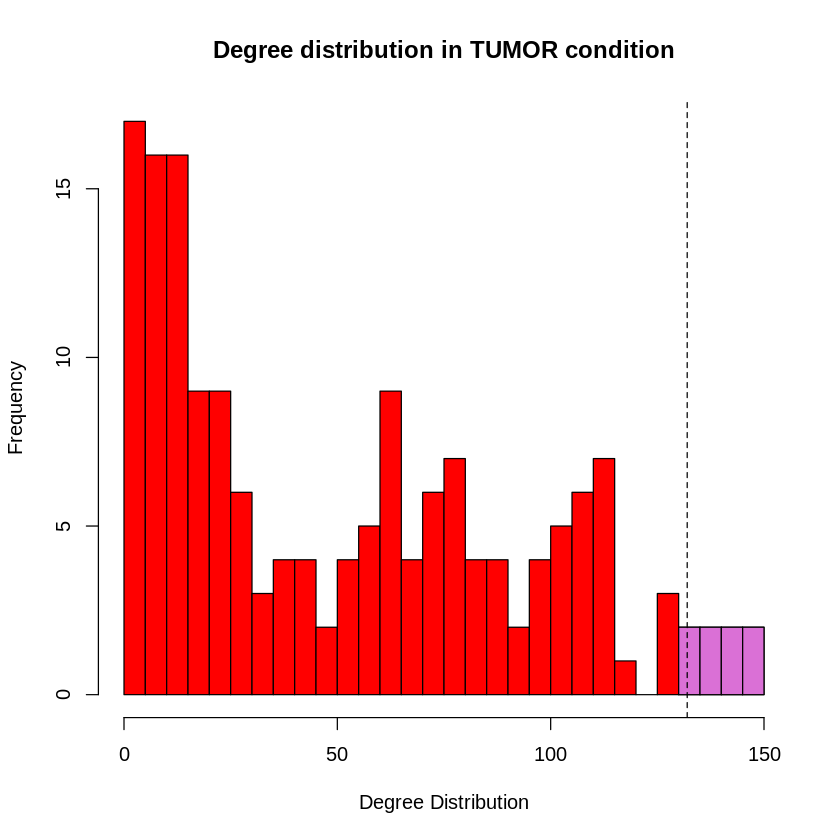

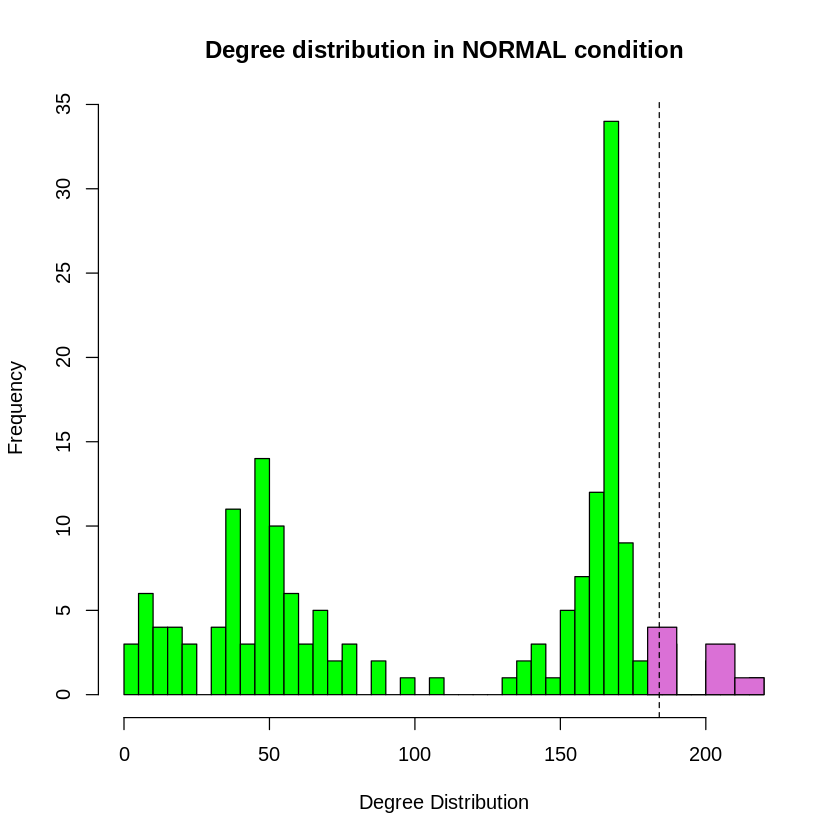

In [72]:
# plot the distribution highliting the 5% of hubs

hist(dgC[dgC != 0], main = "Degree distribution in TUMOR condition", col = "red", xlab = "Degree Distribution", breaks = 50)
hist(hubs_C, add = T, col = "orchid")
abline(v = tail(hubs_C, n=1), lty = 2)
hist(dgN[dgN != 0], main = "Degree distribution in NORMAL condition", col = "green", xlab = "Degree Distribution", breaks = 50)
hist(hubs_N, add = T, col = "orchid")
abline(v = tail(hubs_N, n=1), lty = 2)

In [73]:
# find the hubs 

namesHUBS_C <- names(hubs_C)
namesHUBS_N <- names(hubs_N)

namesHUBS_C_df <- data.frame(gene = namesHUBS_C, degree = hubs_C, row.names = 1:length(namesHUBS_C)); namesHUBS_C_df
namesHUBS_N_df <- data.frame(gene = namesHUBS_N, degree = hubs_N, row.names = 1:length(namesHUBS_N)); namesHUBS_N_df

gene               degree
1 ENSG00000176928.7  148   
2 ENSG00000099957.16 148   
3 ENSG00000128266.9  144   
4 ENSG00000103485.19 142   
5 ENSG00000120885.22 138   
6 ENSG00000152137.8  138   
7 ENSG00000109846.9  132   
8 ENSG00000244509.4  132

gene               degree
1 ENSG00000100505.13 216   
2 ENSG00000147234.10 208   
3 ENSG00000128266.9  204   
4 ENSG00000048540.15 202   
5 ENSG00000118298.12 188   
6 ENSG00000087258.16 188   
7 ENSG00000125257.16 186   
8 ENSG00000136840.19 184

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


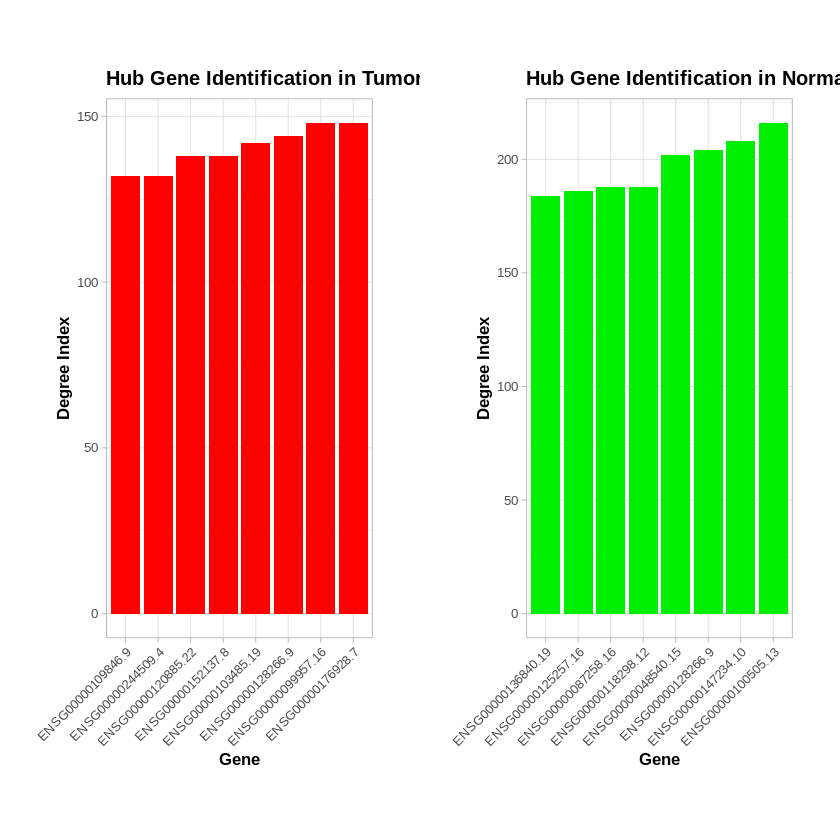

In [74]:
histcol <- c("degree_N" = "green2", "degree" = "red")
hub_gene_C_plot <- ggplot(data = namesHUBS_C_df, aes(x = reorder(gene, degree), y = degree)) +
                      geom_col(aes(x = reorder(gene, degree), y = degree, fill = "degree")) +
                      theme_light() + 
                      theme(text = element_text(size=10),
                            axis.text.x = element_text(angle = 45,hjust = 1),
                            axis.title.x = element_text(face="bold"),
                            axis.title.y = element_text(face="bold"),
                            plot.margin=unit(c(t = 1.5, r = 1, b = 1.5, l = 1.2), "cm"),
                            plot.title = element_text(face = "bold")) +
                      labs( y = "Degree Index", x = "Gene") +
                      scale_fill_manual(values= histcol) +
                      ggtitle("Hub Gene Identification in Tumor Condition") +
                      guides(fill=FALSE)

hub_gene_N_plot <- ggplot(data = namesHUBS_N_df, aes(x = reorder(gene, degree), y = degree)) +
                      geom_col(aes(x = reorder(gene, degree), y = degree, fill = "degree_N")) +
                      theme_light() + 
                      theme(text = element_text(size=10),
                            axis.text.x = element_text(angle = 45,hjust = 1),
                            axis.title.x = element_text(face="bold"),
                            axis.title.y = element_text(face="bold"),
                            plot.margin=unit(c(t = 1.5, r = 1, b = 1.5, l = 1.2), "cm"),
                            plot.title = element_text(face = "bold")) +
                      labs( y = "Degree Index", x = "Gene") +
                      scale_fill_manual(values = histcol) +
                      ggtitle("Hub Gene Identification in Normal Condition") +
                      guides(fill=FALSE)

plot_grid(hub_gene_C_plot, hub_gene_N_plot, labels = NULL)

### 3) Hubs in common (Tumor and Normal)

In [75]:
# Common Hubs

intersect(namesHUBS_C, namesHUBS_N) 

[1] "ENSG00000128266.9"

In [76]:
# Check the closeness to confirm

sort(closeness(gC), decreasing = T)[1:10]

ENSG00000176928.7  ENSG00000128266.9 ENSG00000103485.19 ENSG00000099957.16 
       0.003039514        0.002949853        0.002941176        0.002923977 
 ENSG00000152137.8 ENSG00000120885.22 ENSG00000197705.10  ENSG00000244509.4 
       0.002923977        0.002915452        0.002890173        0.002873563 
 ENSG00000256751.6 ENSG00000131620.17 
       0.002873563        0.002849003

### 4) Extra Statistics about Hubs

In [77]:
# Up-regulated  (Tumor)
upgenes <- final_dt[final_dt$log2FoldChange >= 1.2, ]
hub_upgenes <- na.omit(upgenes[namesHUBS_C, ]) 

# Down-regulated (Tumor)
downgenes <- final_dt[final_dt$log2FoldChange <= 1.2, ]
hub_downgenes <- na.omit(downgenes[namesHUBS_C, ])

# Up-regulated (Normal)
upgenes_N <- final_dt[final_dt$log2FoldChange >= 1.2, ]
hub_upgenes_N <- na.omit(upgenes_N[namesHUBS_N, ])

# Down-regulated (Normal)
downgenes_N <- final_dt[final_dt$log2FoldChange <= 1.2, ]
hub_downgenes_N <- na.omit(downgenes_N[namesHUBS_N, ])

# e.g
hub_downgenes

baseMean    log2FoldChange lfcSE     stat      pvalue      
ENSG00000176928.7    350.62040 -2.129471      0.2081403 -4.465600 7.984480e-06
ENSG00000099957.16    61.90144 -2.173122      0.2185596 -4.452432 8.490298e-06
ENSG00000128266.9   1047.68602 -1.829204      0.1747793 -3.599990 3.182292e-04
ENSG00000103485.19  1018.95367 -2.688366      0.2167354 -6.867204 6.547219e-12
ENSG00000120885.22 72647.65982 -2.905137      0.2349149 -7.258528 3.913241e-13
ENSG00000152137.8  10286.80835 -1.860382      0.1725229 -3.827792 1.292978e-04
ENSG00000109846.9   5831.58757 -1.893310      0.1707230 -4.061019 4.885900e-05
ENSG00000244509.4   3649.88921 -1.776065      0.1583478 -3.637975 2.747905e-04
                   padj        
ENSG00000176928.7  1.535626e-03
ENSG00000099957.16 1.599240e-03
ENSG00000128266.9  3.642100e-02
ENSG00000103485.19 5.201054e-09
ENSG00000120885.22 3.763096e-10
ENSG00000152137.8  1.652028e-02
ENSG00000109846.9  7.084943e-03
ENSG00000244509.4  3.260193e-02

## PART IV 
## Differential Coexpression Network

### IV.1 Find the optimal Z-treshold
See III.4 as a reference for this part

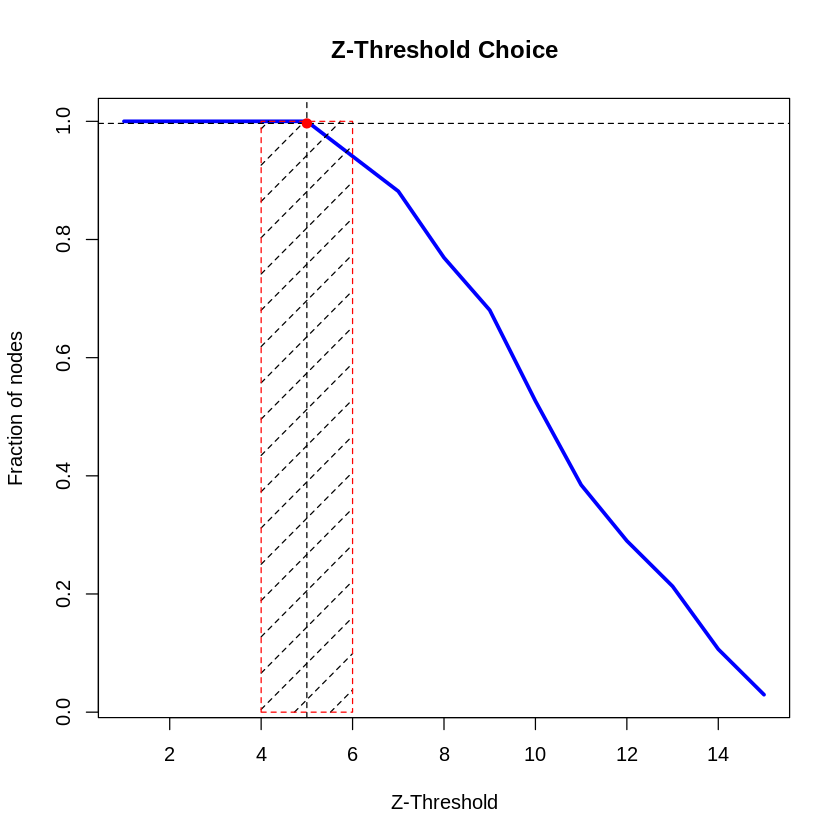

In [78]:
OptimalThresholdingZ <- function(dt, dt2, x){
  # create the correlation datasets for plotting the network for each graph
  co_net_corr_dataC <- cor(t(dt), method = "pearson")
  co_net_corr_dataN <- cor(t(dt2), method = "pearson")
  
  # Application Z-Fisher Transform
  ZcoDataC <- log((1+co_net_corr_dataC)/(1-co_net_corr_dataC))/2
  ZcoDataN <- log((1+co_net_corr_dataN)/(1-co_net_corr_dataN))/2
  
  # Applying z-scores
  ZcoData <- (ZcoDataC-ZcoDataN)/sqrt((1/(nrow(rna_expr_data_C)-3)) + (1/(nrow(rna_expr_data_N)-3)))
  
  # Applying Z-tsh
  tshZ <- x
  ZcoData <- ifelse(ZcoData <= -abs(tshZ) | ZcoData >= abs(tshZ), 1, 0)
  
  gZ <- graph_from_adjacency_matrix(ZcoData, diag = FALSE)
  
  fracNodes_C <- fractionNodes(gZ)
  
  return(fracNodes_C)
}

possibletshZ <- seq(1, 15, by = 1) 
densitiesZ <- unlist(lapply(possibletshZ, function(x){
  return(OptimalThresholdingZ(rna_expr_data_C, rna_expr_data_N, x))
}))

plot(possibletshZ, densitiesZ, col = "blue", type = "l", lwd = 3, xlab = "Z-Threshold", ylab = "Fraction of nodes", main = "Z-Threshold Choice")
rect(xleft = 4, ybottom = 0.0, xright = 6, ytop = 1.0, density = 5, border = "red", lty = 2, lwd = 1)

# hard Zthresholding
abline(h = 0.9965, lty=2)
abline(v = 5, lty=2)
points(x = 5, y = 0.9965, pch = 20, col = "red", cex = 1.5)

### IV.2 Correlation and Z-Transform

In [79]:
# create the correlation datasets for plotting the network for each graph
co_net_corr_dataC <- cor(t(rna_expr_data_C), method = "pearson")
co_net_corr_dataN <- cor(t(rna_expr_data_N), method = "pearson")

# Application Z-Fisher Transform
ZcoDataC <- log((1+co_net_corr_dataC)/(1-co_net_corr_dataC))/2
ZcoDataN <- log((1+co_net_corr_dataN)/(1-co_net_corr_dataN))/2

# Applying z-scores
ZcoData <- (ZcoDataC-ZcoDataN)/sqrt((1/(nrow(rna_expr_data_C)-3)) + (1/(nrow(rna_expr_data_N)-3)))

# Z-Threshold it
tshZ <- 5 
ZcoData <- ifelse(ZcoData <= -abs(tshZ) | ZcoData >= abs(tshZ), 1, 0)

### IV.3 Hubs of genes
See III.4 as a reference for this part

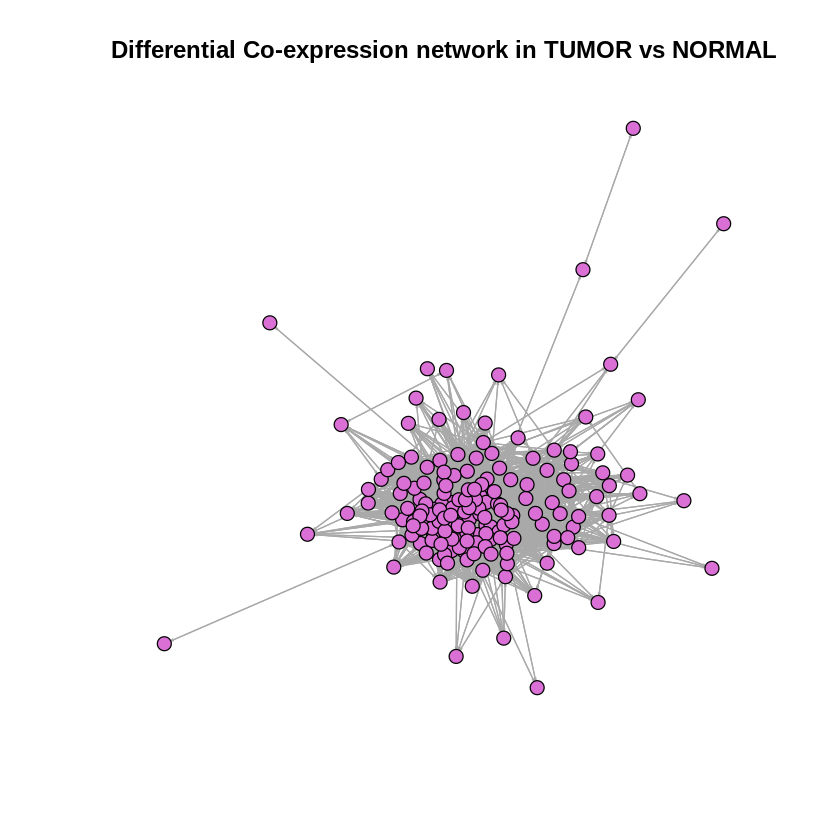

character(0)


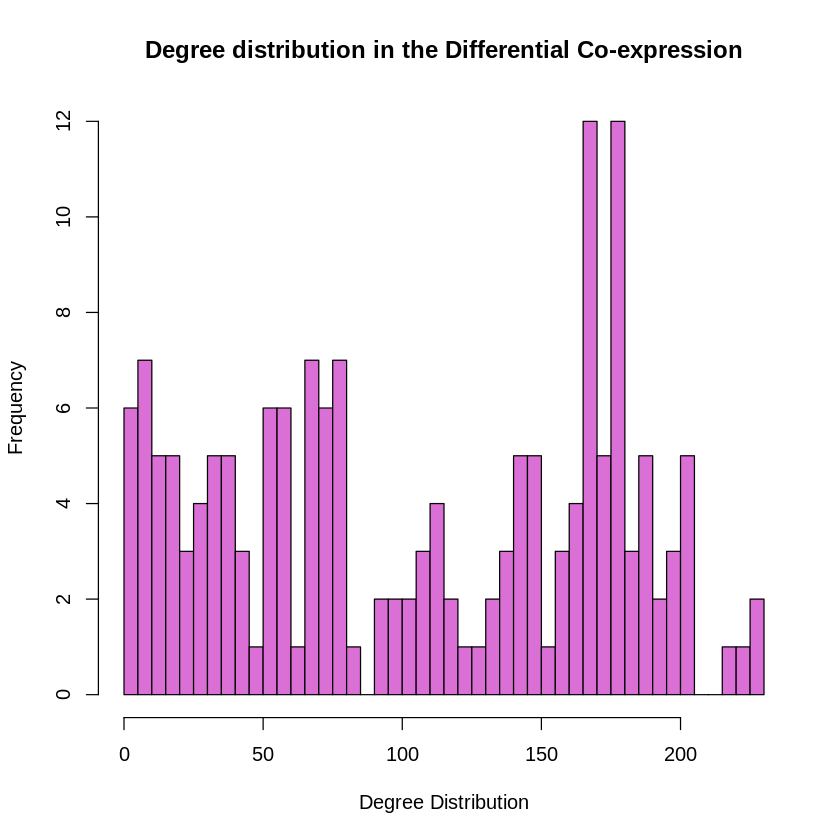

In [80]:
# Get the graph and plot it
gZcoData <- graph_from_adjacency_matrix( ZcoData, diag = FALSE)
plot(gZcoData, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "orchid", main = "Differential Co-expression network in TUMOR vs NORMAL",
     arrow.width=.1, edge.arrow.size=.1, layout= layout.auto, vertex.label = NA)

# dgZcoData degree distribution
dgZcoData <- degree(gZcoData)
hist(dgZcoData[dgZcoData != 0], main = "Degree distribution in the Differential Co-expression", col = "orchid", xlab = "Degree Distribution", breaks = 50)

# extract the 5% of HUBS, in their conditions
hubs_Z <- sort(degree(gZcoData, v = V(gZcoData), mode = "all"), decreasing = TRUE) 
hubs_Z <- hubs_Z[1:floor(0.05 * length(hubs_Z))] 

# Comparing hubs in TUMORS and Z-Tum vs. Z-Norm
namesHUBS_Z <- names(hubs_Z)
namesHUBS_C <- names(hubs_C)
namesHUBS_N <- names(hubs_N)

hubs_commonZC <- intersect(namesHUBS_C, namesHUBS_Z) 
print(hubs_commonZC)

## Part V
## Patient Similarity Network (PSN)
We will run community detection using Clustering (Jaccard Similarity) and the Louvain method (see https://en.wikipedia.org/wiki/Louvain_method) in igraph. For further references see https://kateto.net/networks-r-igraph and https://air.unimi.it/retrieve/1c59e885-670b-4320-89e5-fd9f49691632/bbac207.pdf. 

#### 1) Jaccard Clustering

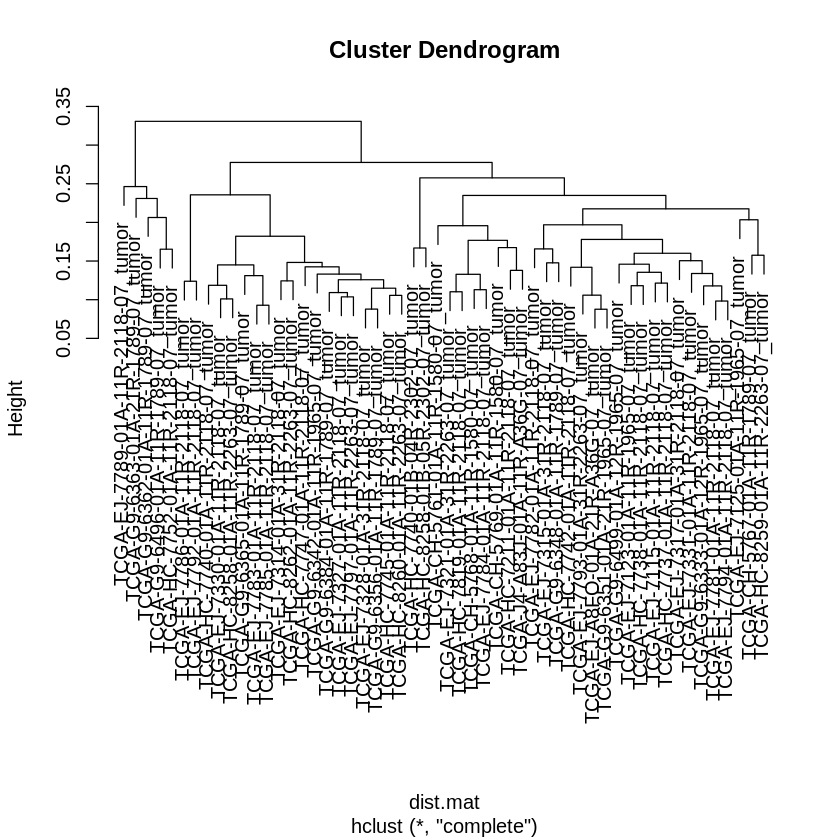

In [81]:
# Use Jaccard similarity on transposed rna_expr_data_C matrix

dist.mat<-vegdist(t(rna_expr_data_C), method="jaccard")
clust.res<-hclust(dist.mat)
plot(clust.res)

In [82]:
clust.res


Call:
hclust(d = dist.mat)

Cluster method   : complete 
Distance         : jaccard 
Number of objects: 54 


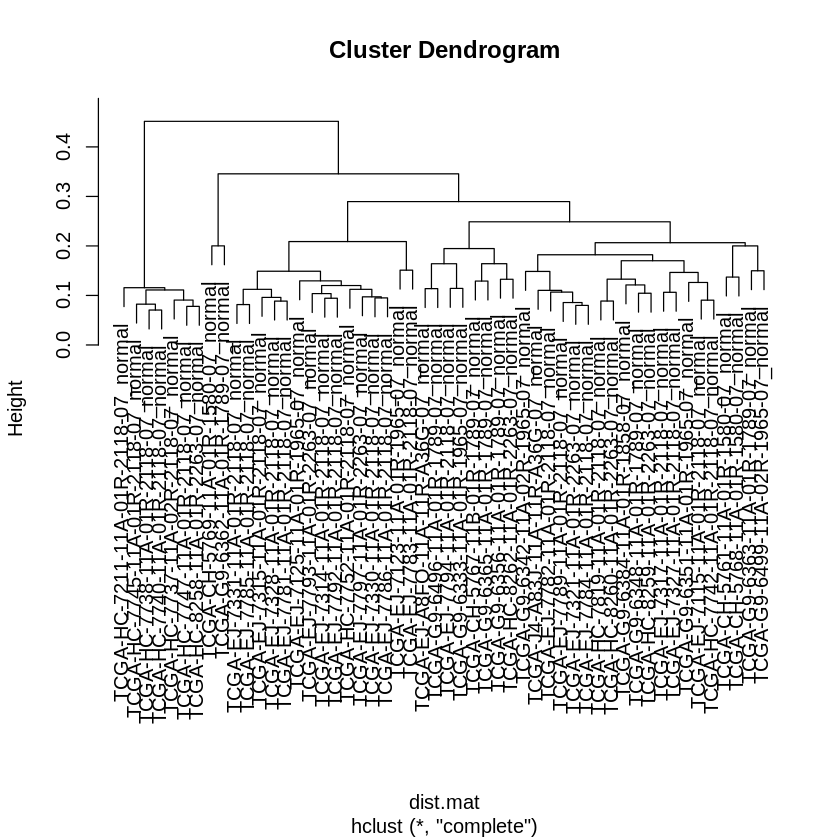

In [83]:
# Use Jaccard similarity on transposed rna_expr_data_N matrix

dist.mat<-vegdist(t(rna_expr_data_N), method="jaccard")
clust.res<-hclust(dist.mat)
plot(clust.res)

In [84]:
clust.res


Call:
hclust(d = dist.mat)

Cluster method   : complete 
Distance         : jaccard 
Number of objects: 52 


#### 2) Luvian method

In [85]:
# Patient-Cancer Gene Expression Graph
# ERROR HERE <-> Change co_net_corrBinary_dataC 
distancematrix <- cor2dist(rna_expr_data_N)
DM <- as.matrix(distancematrix)
G <- graph.adjacency(DM, mode = "undirected", weighted = TRUE, diag = TRUE)

Community sizes
 1 
52 

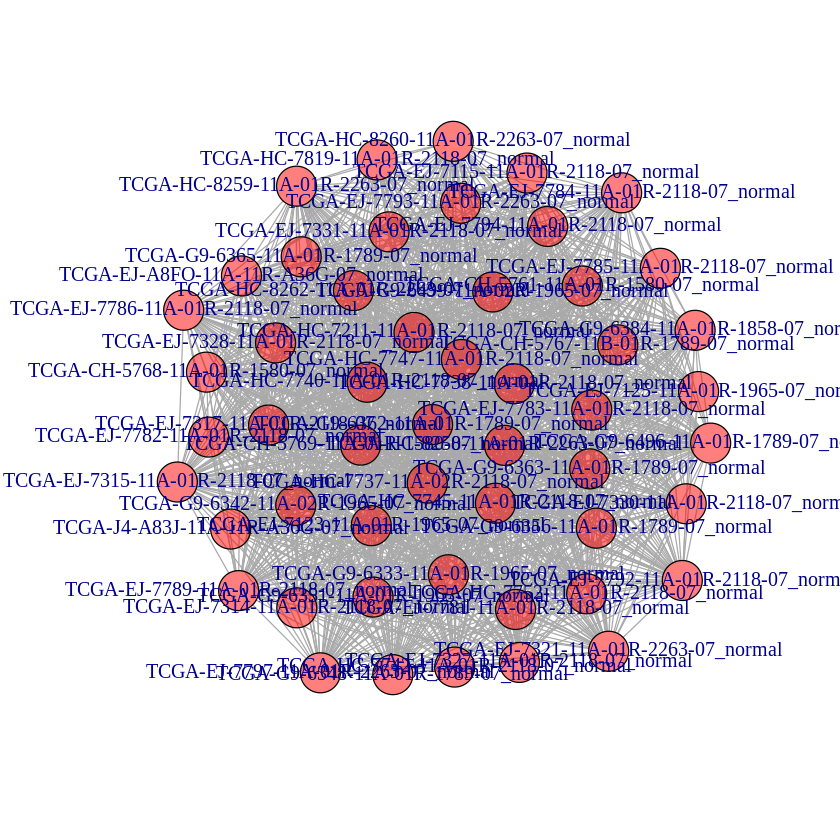

In [86]:
# communities
clusterlouvain <- cluster_louvain(G)
plot(G, vertex.color=rainbow(4, alpha=0.5)[clusterlouvain$membership])
sizes(clusterlouvain)

In [87]:
# Clearer plot
#plot(G, vertex.size=7, edge.curverd=.001, arrow.size=.001, vertex.color=rainbow(4, alpha=0.5)[clusterlouvain$membership])

In [88]:
# Other plots
# See https://www.bioconductor.org/packages/release/bioc/vignettes/netbiov/inst/doc/netbiov-intro.pdf

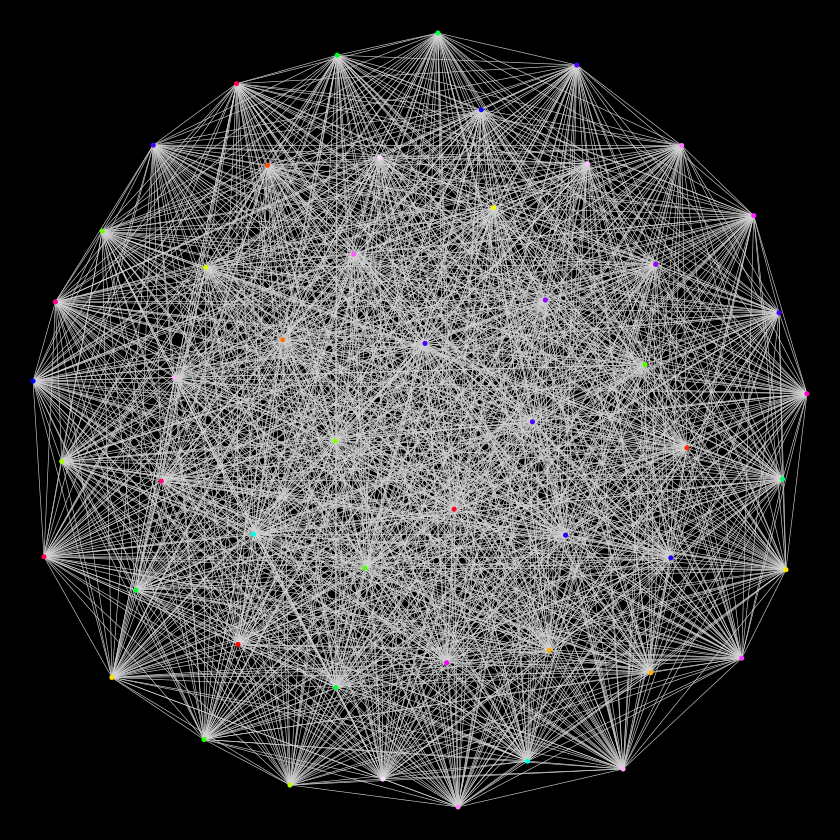

In [89]:
xx<-plot.modules(G, color.random=TRUE, v.size=1,layout.function=layout.graphopt)

In [90]:
#hc <- rgb(t(col2rgb(heat.colors(20)))/255,alpha=.2)
#cl <- rgb(r=1, b=.7, g=0, alpha=.1)
#xx <- mst.plot.mod(G, vertex.color=cl, v.size=3, sf=-20,colors=hc, e.size=.5, mst.e.size=.75,layout.function=layout.fruchterman.reingold)

In [91]:
#ecl <- rgb(r=0, g=1, b=1, alpha=.6)
#ppx <- mst.plot.mod(G, v.size=degree(G),e.size=.5,colors=ecl,mst.e.size=1.2,expression=degree(G),mst.edge.col="white", sf=-10, v.sf=6)

In [92]:
#cl <- rgb(r=.6, g=.6, b=.6, alpha=.5)
#xx <- level.plot(G, init_nodes=20,tkplot=FALSE, level.spread=TRUE,order_degree=NULL, v.size=1, edge.col=c(cl, cl, "green", cl),vertex.colors=c("red", "red", "red"), e.size=.5, e.curve=.25)

## PART VI
## Optional Tasks

#### VI.1 Compare the network topology obtained applying hard-thresholding and soft-thresholding

##### Case of Patients with Cancer

 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 169 of 169


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0689  0.311         0.1020 41.3000  40.90000 66.500
2      2   0.5420 -0.498         0.4640 16.5000  14.50000 37.400
3      3   0.7740 -0.792         0.7720  8.1800   6.07000 23.900
4      4   0.7910 -0.927         0.7900  4.5900   2.68000 16.300
5      5   0.8730 -0.992         0.8700  2.7800   1.43000 11.600
6      6   0.9020 -1.080         0.9240  1.7700   0.82000  8.490
7      7   0.8300 -1.130         0.8300  1.1800   0.45400  6.410
8      8   0.8020 -1.180         0.7970  0.8110   0.29600  4.950
9      9   0.8600 -1.180         0.8760  0.5720   0.18500  3.890
10    10   0.1710 -2.110        -0.0654  0.4130   0.12800  3.090
11    12   0.1720 -2.020        -0.0616  0.2270   0.05450  2.020
12    14   0.2070 -2.090         0.0155  0.1330   0.02250  1.360
13    16   0.2740 -3.140         0.2230  0.0815   0.00986  0.943
14    18   0.3020 -3.730         0.2130  0.0519   0.00469  0.668
15    20   0.3050 -3.590 

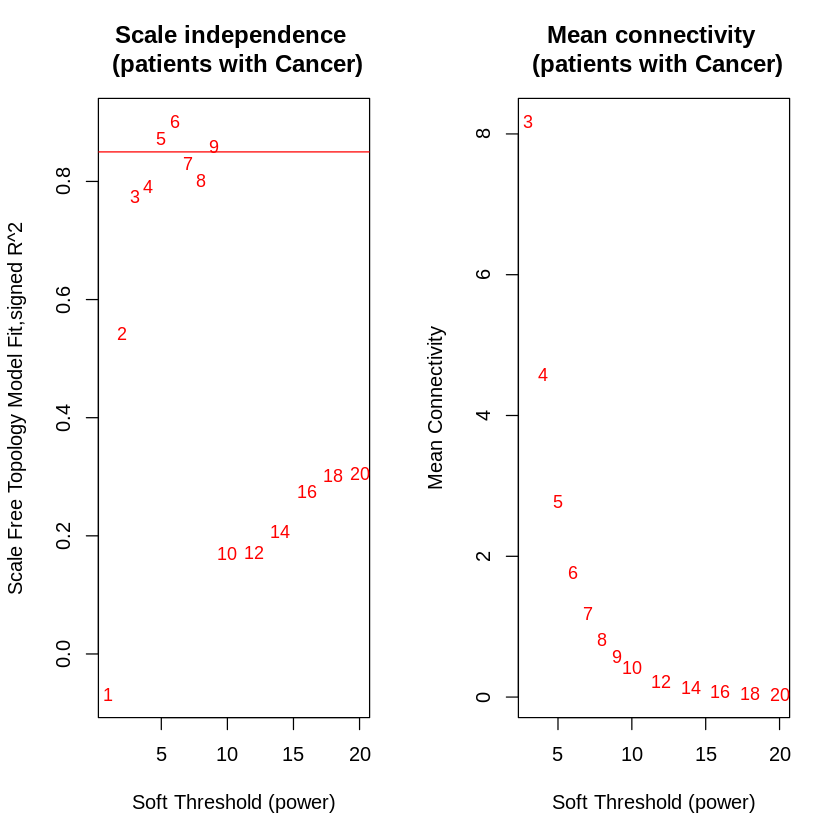

scaleFreeRsquared slope
1 0.91              -1.74

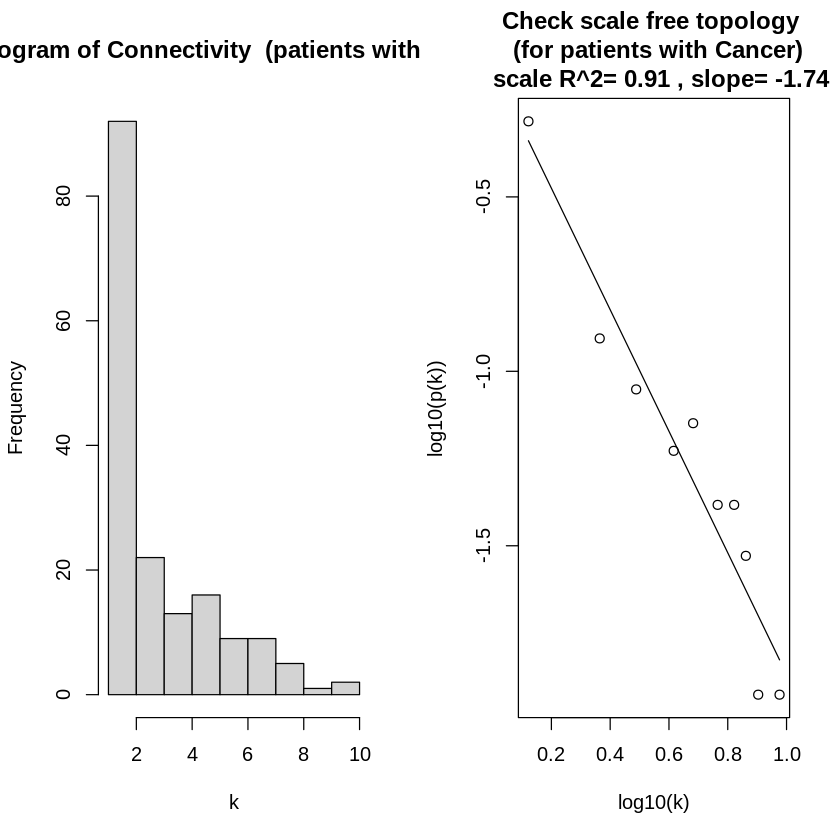

In [93]:
# Choose a set of soft-thresholding powers 
# See https://support.bioconductor.org/p/87024

powers = c(c(1:10), seq(from = 12, to=20, by=2)) 

# Call the WGCNA function 
sft = pickSoftThreshold(t(rna_expr_data_C), powerVector = powers, verbose = 5,blockSize=8504) 

par(mfrow = c(1,2))

# Analysis of the scale-free fit index for various soft-thresholding powers 
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n", main = "Scale independence \n (patients with Cancer)");
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], labels=powers,cex=0.9,col="red")
# this line corresponds to using an R^2 cut-off of 0.85
abline(h=0.85,col="red") 

# Analysis of the mean connectivity for various soft-thresholding powers  
plot(sft$fitIndices[-(1:2),1], sft$fitIndices[-(1:2),5], xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n", main = "Mean connectivity \n (patients with Cancer)") 
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=0.9, col="red")

# It seems that 6 could be a power soft threshold to ensure a scale-free network
soft_th = 6

# Calculate the corresponding adjacency matrix:
adjacency=abs(cor(t(rna_expr_data_C),use="p"))^soft_th

# Network connectivities
k=as.vector(apply(adjacency,2,sum))

# The following histogram shows the frequency distribution of the connectivity
hist(k, main="Histogram of Connectivity  (patients with Cancer)")

# The following log-log plot shows the value of R2 (the scale-free topology index)
scaleFreePlot(k, main="Check scale free topology \n (for patients with Cancer)\n")


##### Case of Patients without Cancer 

 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 169 of 169
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.867  1.680         0.8870  71.300    78.800 101.00
2      2    0.251  0.315         0.1020  40.600    43.800  73.50
3      3    0.161 -0.256        -0.0591  26.300    25.200  57.80
4      4    0.454 -0.533         0.3050  18.400    15.600  47.40
5      5    0.574 -0.672         0.4760  13.500     9.790  39.90
6      6    0.580 -0.858         0.5200  10.300     6.470  34.10
7      7    0.641 -0.868         0.6120   8.060     4.350  29.50
8      8    0.671 -0.917         0.6330   6.420     2.960  25.80
9      9    0.643 -1.030         0.6190   5.200     2.040  22.70
10    10    0.677 -1.030         0.6820   4.260     1.450  20.10
11    12    0.736 -1.040         0.7540   2.960     0.855  16.00
12    14    0.203 -2.250         0.1210   2.110     0.441  12.90
13    16    0.210 -2.130         0.1290   1.550

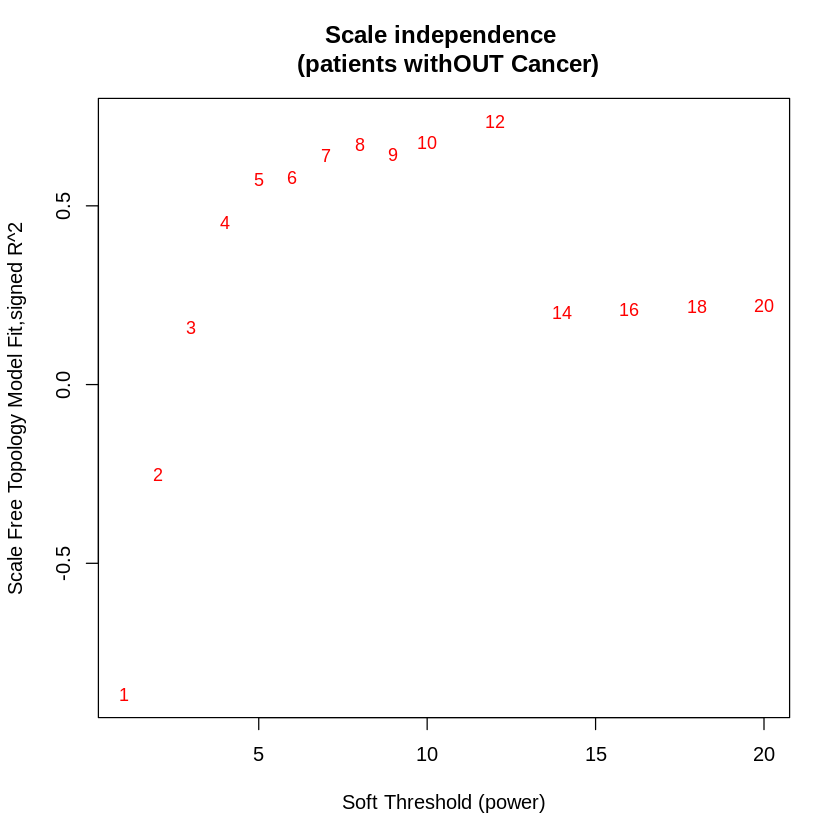

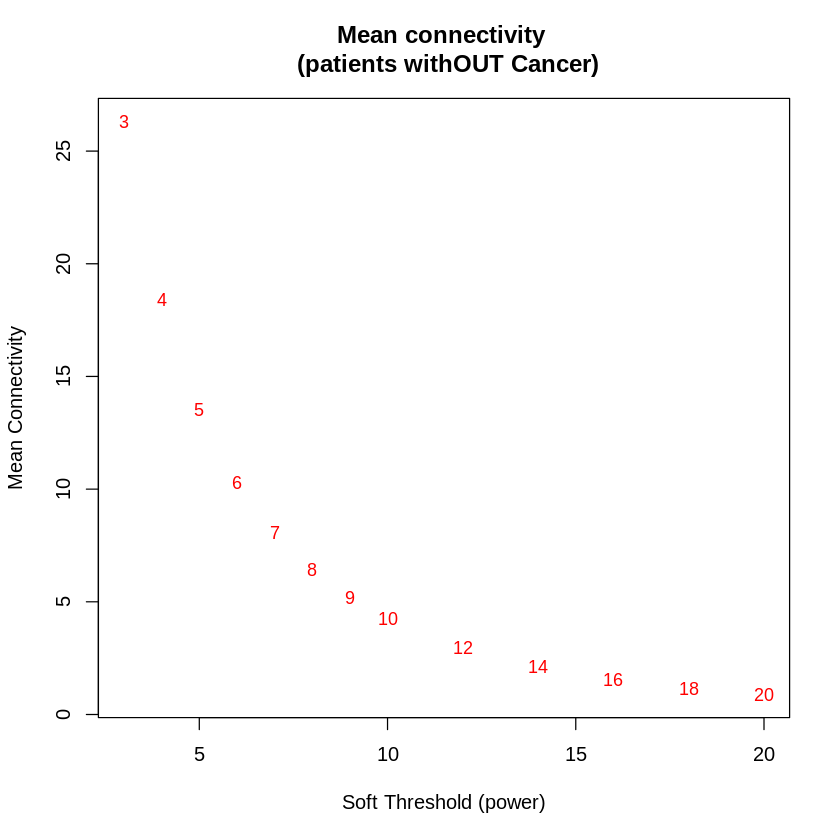

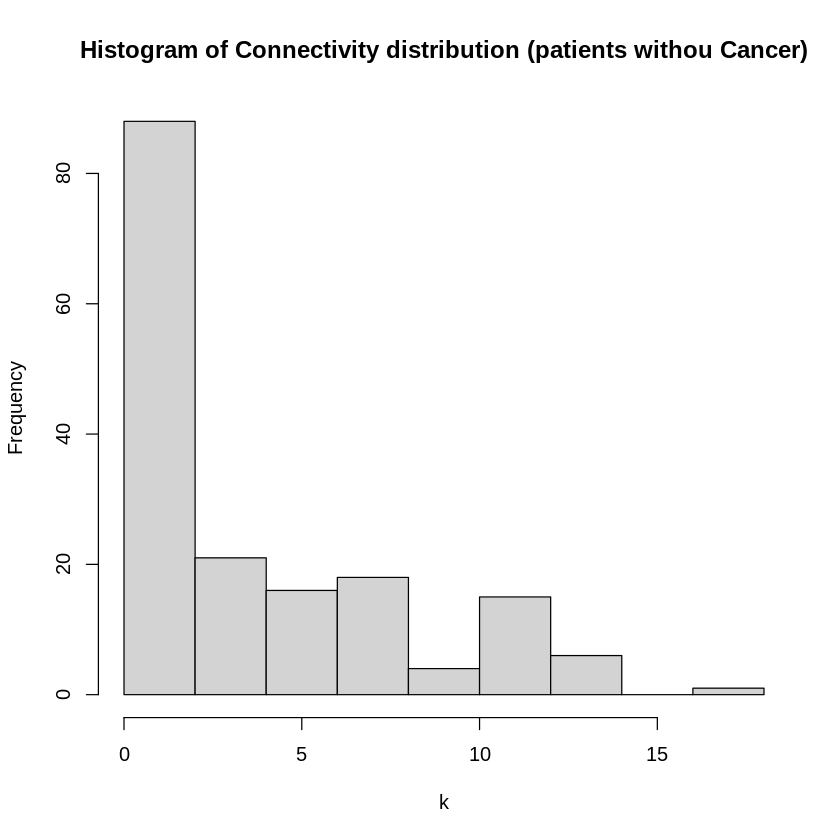

scaleFreeRsquared slope
1 0.74              -1.56

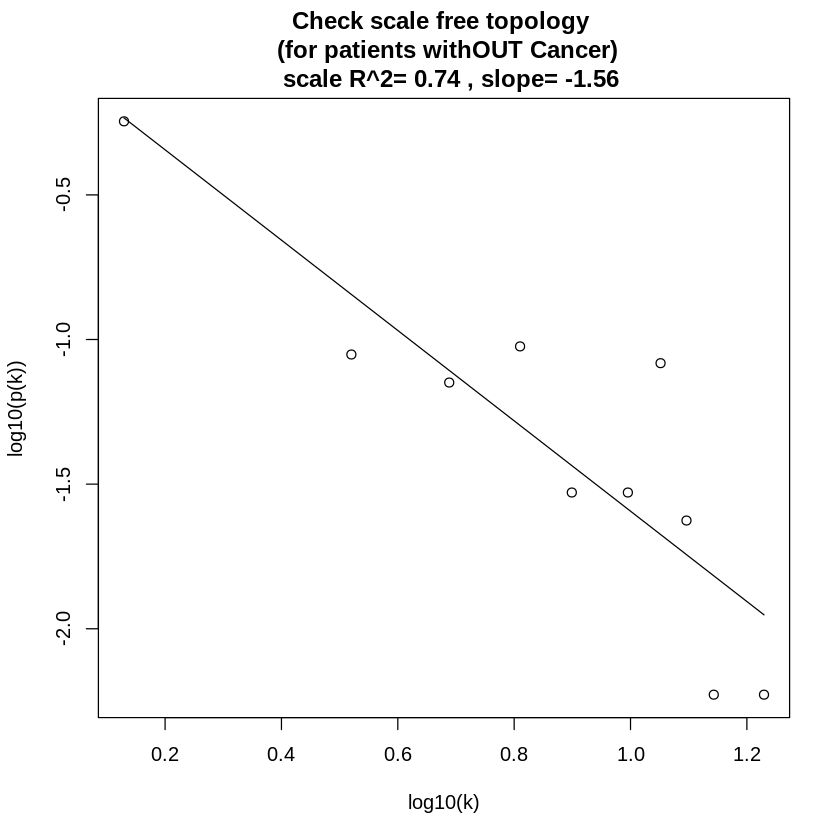

In [94]:
# Choose a set of soft-thresholding powers 
powers = c(c(1:10), seq(from = 12, to=20, by=2)) 

# Call the WGCNA function 
sft = pickSoftThreshold(t(rna_expr_data_N), powerVector = powers, verbose = 5,blockSize=8504) 

# Analysis of the scale-free fit index for various soft-thresholding powers (??)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n", main = "Scale independence \n (patients withOUT Cancer)");
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], labels=powers,cex=0.9,col="red")
abline(h=0.85,col="red") # this line corresponds to using an R^2 cut-off of 0.85

# Analysis of the mean connectivity for various soft-thresholding powers  
plot(sft$fitIndices[-(1:2),1], sft$fitIndices[-(1:2),5], xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n", main = "Mean connectivity \n (patients withOUT Cancer)") 
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=0.9, col="red")

# It seems that 12 could be a power soft threshold to ensure a scale-free network, so:
soft_th = 12

# Calculate the corresponding adjacency matrix:
adjacency=abs(cor(t(rna_expr_data_N),use="p"))^soft_th

# Network connectivity:
k=as.vector(apply(adjacency,2,sum))

# The following histogram shows the frequency distribution of the connectivity
hist(k, main="Histogram of Connectivity distribution (patients withou Cancer)")

# The following log-log plot shows the value of R2 (the scale-free topology index)
scaleFreePlot(k, main="Check scale free topology \n (for patients withOUT Cancer)\n")

### VI.2 Check the overlapping between the 5% of the nodes with highest CI values and the "Degree"-based hubs

In [95]:
comparisonCIwithDegreeHUBS <- function(graph, TypegHUBS) {
  
  # Calculates the centralities
  # Betweenness centrality
  CI_index_between <- sort(betweenness(graph), decreasing = T) 
  # Closeness centrality
  CI_index_closeness <- sort(closeness(graph), decreasing = T) 
  # Eigen centrality
  CI_index_eigen <- sort(eigen_centrality(graph)$vector, decreasing = T) 
  
  # extract the hubs and their names
  hubs_CI_between <- CI_index_between[1:floor(0.05 * length(CI_index_between))] 
  namesHUBS_CI_between <- names(hubs_CI_between) 
  
  hubs_CI_closeness <- CI_index_closeness[1:floor(0.05 * length(CI_index_closeness))] 
  namesHUBS_CI_closeness <- names(hubs_CI_closeness)
  
  hubs_CI_eigen <- CI_index_eigen[1:floor(0.05 * length(CI_index_eigen))] 
  namesHUBS_CI_eigen <- names(hubs_CI_eigen) 
  
  # put all in a list
  localCentralities <- list(
    betweeness = intersect(TypegHUBS, namesHUBS_CI_between),
    closeness = intersect(TypegHUBS, namesHUBS_CI_closeness),
    eigen = intersect(TypegHUBS, namesHUBS_CI_eigen)
  )
  
  # See which centralityIndex-based hubs are also "Degree"-based hubs
  return(localCentralities) 
}

plotCommonHUBS <- function(matrix_type, graph_type, LocalCentralities_type){ 
  
  for(hubs_type in names(LocalCentralities_type)){
    hub_common <- LocalCentralities_type[[hubs_type]]
    
    V(graph_type)$color <- ifelse(V(graph_type)$name %in% hub_common, "red", "green")
    
    plot(graph_type, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = V(graph_type)$color, main = paste(hubs_type, "=", length(hub_common), "hubs in common", sep = " "),
         arrow.width=.1, edge.arrow.size=.1, layout= layout_on_sphere, vertex.label = NA)
  }
  
}

$betweeness
[1] "ENSG00000176928.7"

$closeness
[1] "ENSG00000176928.7"  "ENSG00000099957.16" "ENSG00000128266.9" 
[4] "ENSG00000103485.19" "ENSG00000120885.22" "ENSG00000152137.8" 
[7] "ENSG00000244509.4" 

$eigen
[1] "ENSG00000176928.7"  "ENSG00000099957.16" "ENSG00000128266.9" 
[4] "ENSG00000103485.19" "ENSG00000120885.22" "ENSG00000152137.8" 
[7] "ENSG00000109846.9"

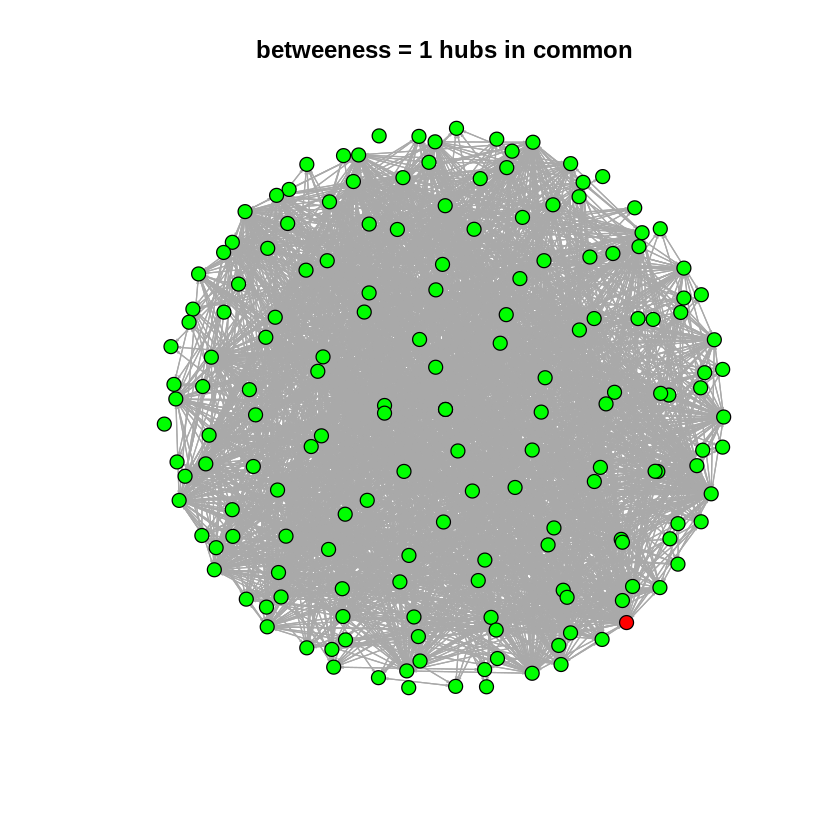

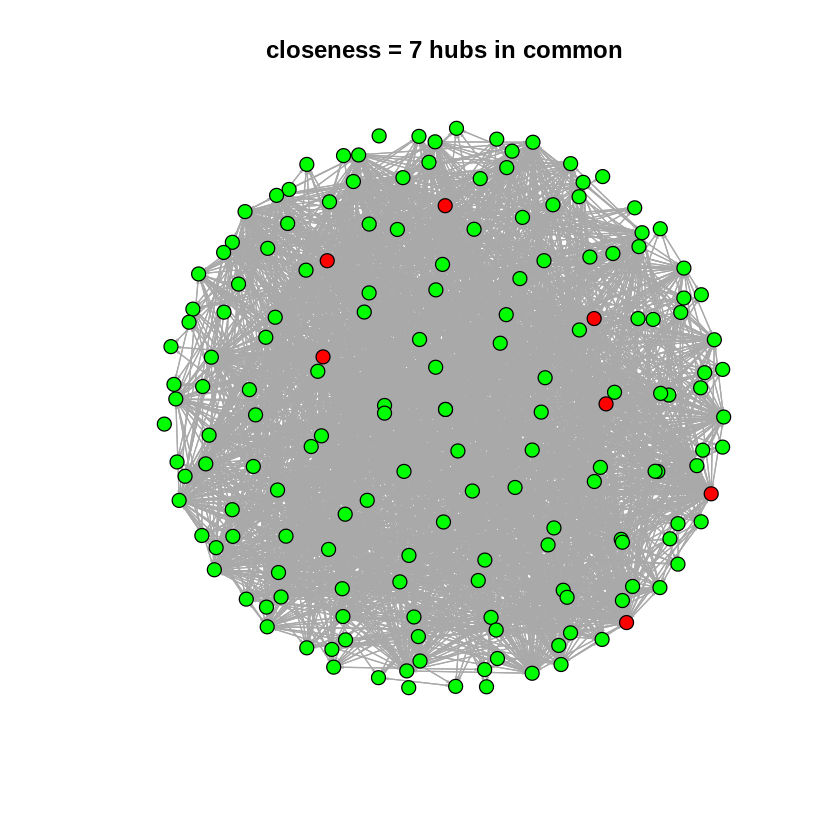

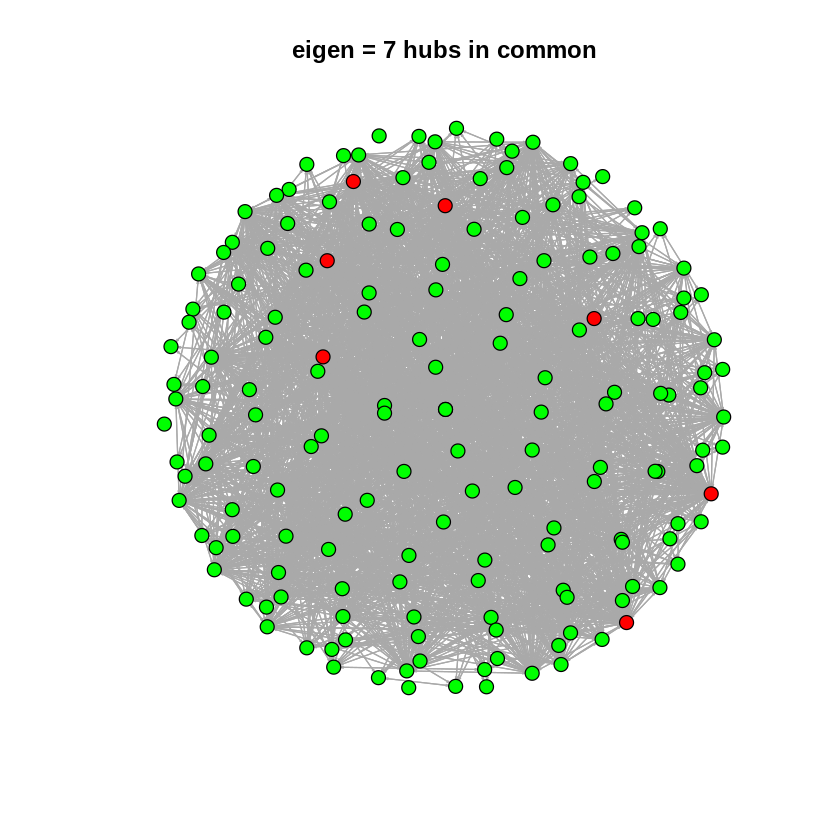

In [96]:
# Centralities and common hubs (Tumor)

LocalCentralities_C <- comparisonCIwithDegreeHUBS(gC, namesHUBS_C); LocalCentralities_C 
plotCommonHUBS(co_net_corrBinary_dataC, gC, LocalCentralities_C) 

$betweeness
[1] "ENSG00000100505.13" "ENSG00000147234.10" "ENSG00000128266.9" 
[4] "ENSG00000048540.15" "ENSG00000125257.16"

$closeness
[1] "ENSG00000100505.13" "ENSG00000147234.10" "ENSG00000128266.9" 
[4] "ENSG00000048540.15" "ENSG00000118298.12" "ENSG00000087258.16"
[7] "ENSG00000125257.16" "ENSG00000136840.19"

$eigen
[1] "ENSG00000118298.12" "ENSG00000087258.16" "ENSG00000136840.19"

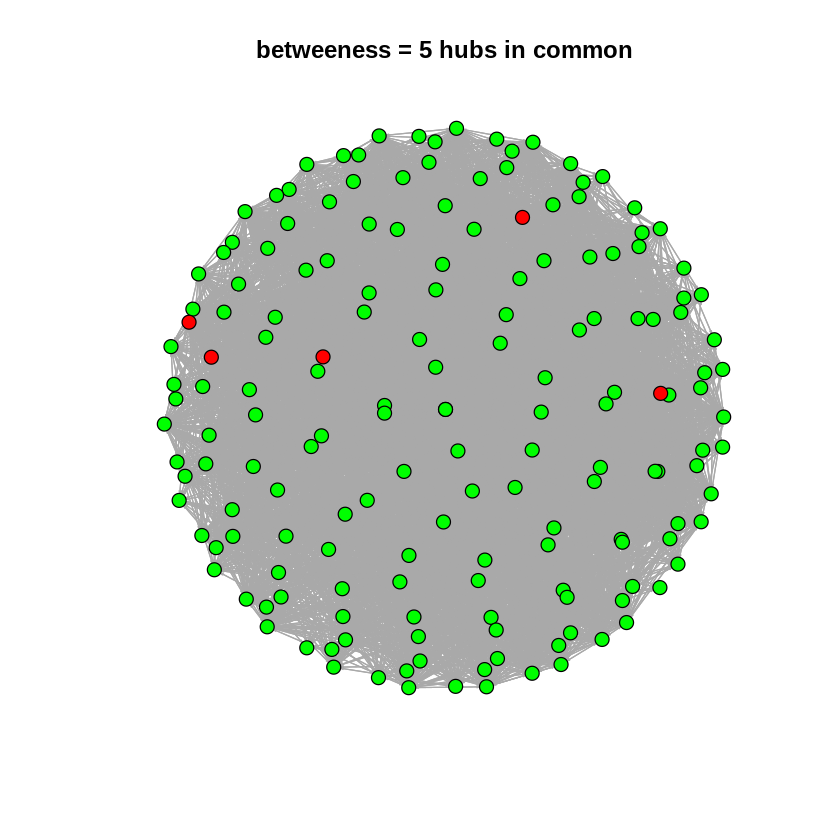

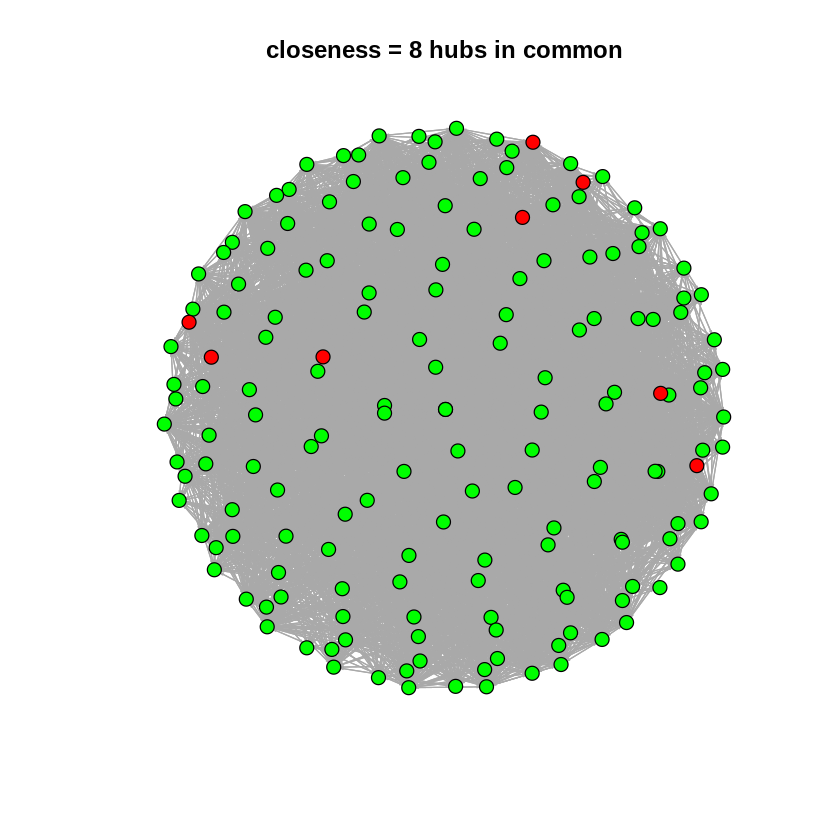

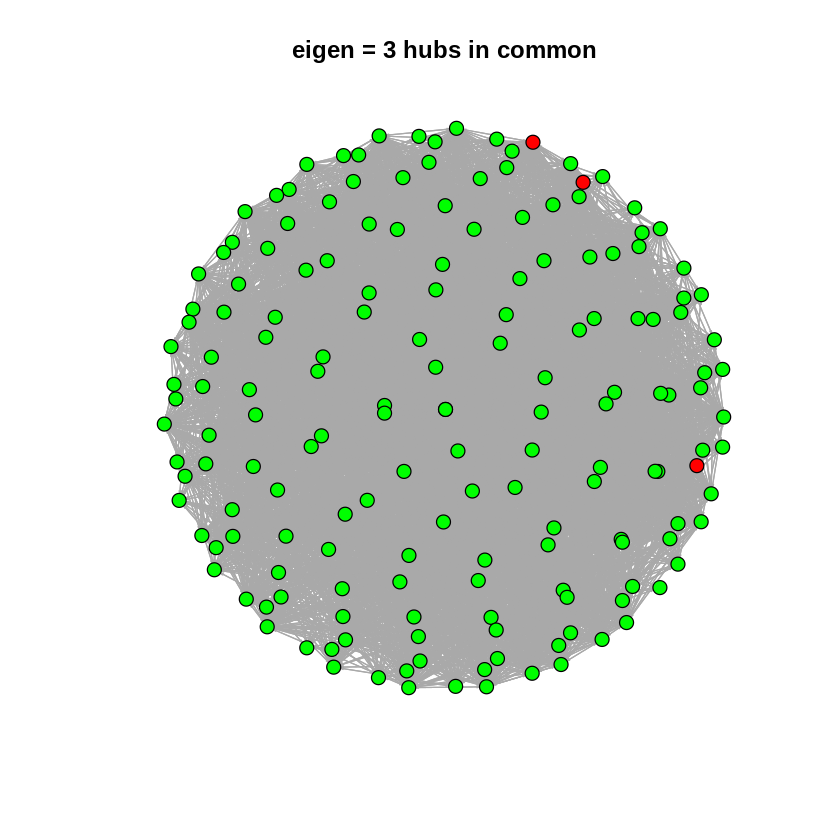

In [97]:
# Centralities and common hubs (Normal)
LocalCentralities_N <- comparisonCIwithDegreeHUBS(gN, namesHUBS_N); LocalCentralities_N 
plotCommonHUBS(co_net_corrBinary_dataN, gN, LocalCentralities_N) 

### VI.3 Perform the study using a different similarity measure

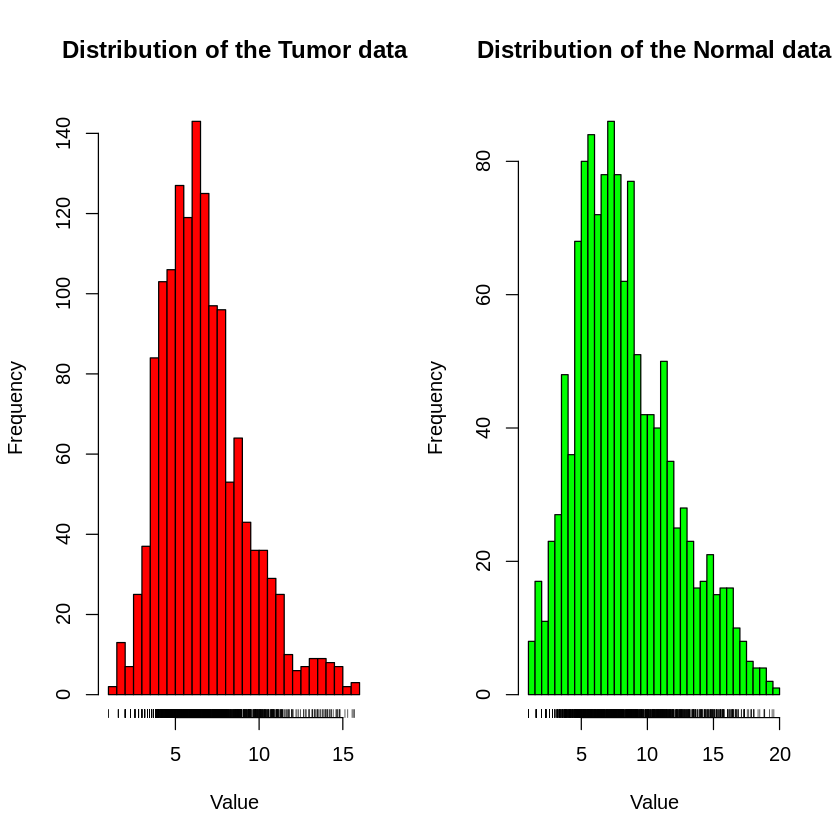

In [98]:
# Print the values to check which value of correlation is better
par(mfrow=c(1,2))
hist(rna_expr_data_C[upper.tri(rna_expr_data_C)], main = "Distribution of the Tumor data", col = "red", xlab = "Value", breaks = 50)
rug(rna_expr_data_C[upper.tri(rna_expr_data_C)])
hist(rna_expr_data_N[upper.tri(rna_expr_data_N)], main = "Distribution of the Normal data", col = "green", xlab = "Value", breaks = 50)
rug(rna_expr_data_N[upper.tri(rna_expr_data_N)])

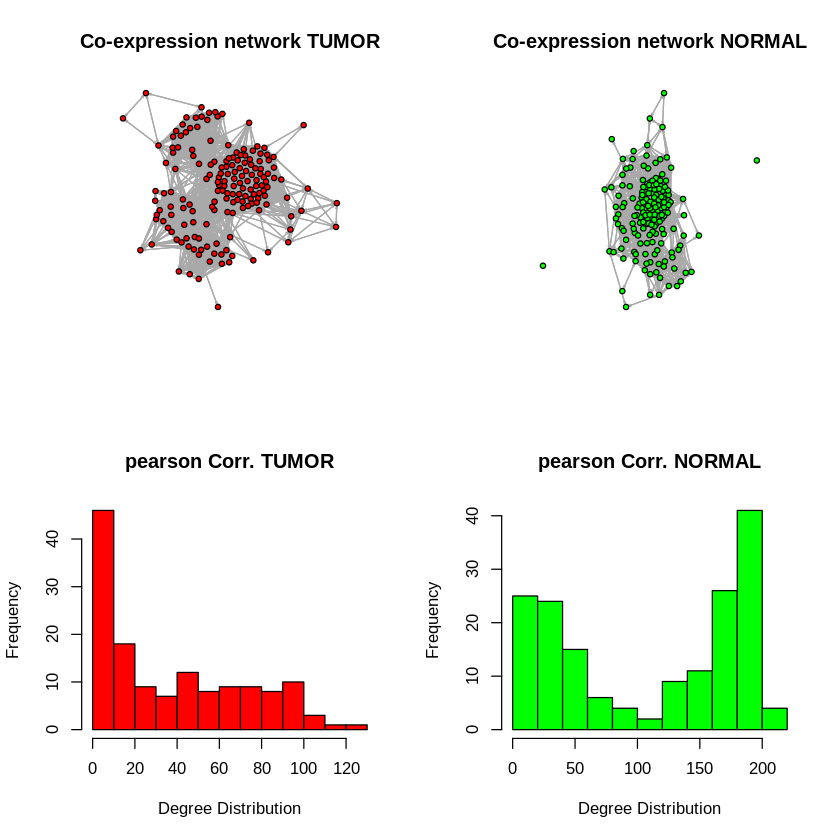

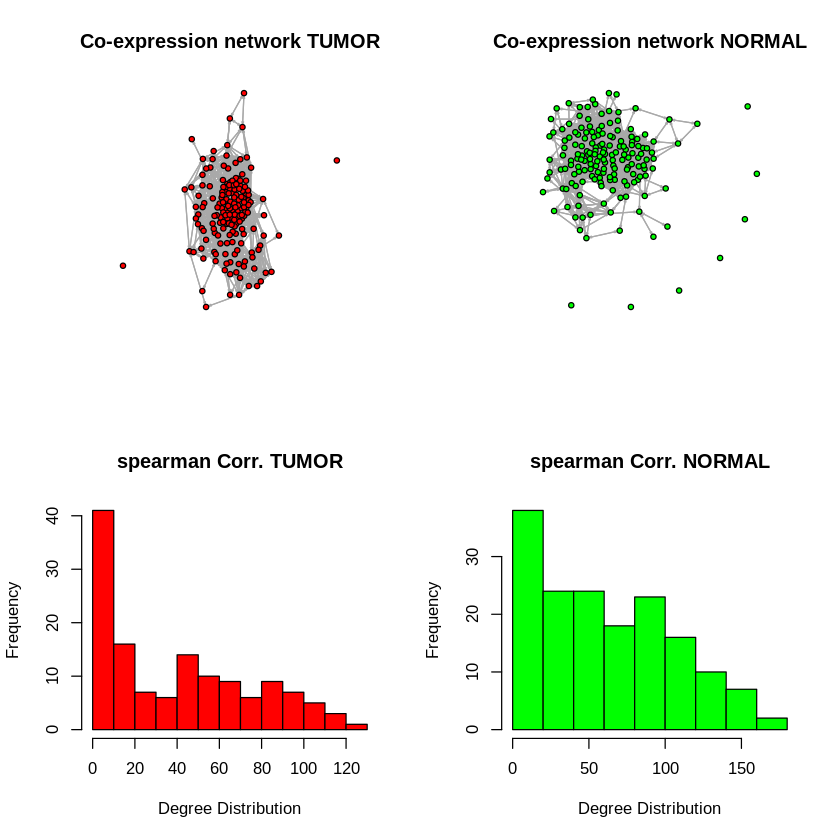

In [99]:
par(mfrow=c(2,2))
method_correlation <- c("pearson", "spearman")
for (i in  method_correlation) {
  # create the correlation datasets for plotting the network for each graph
  co_net_corr_dataC <- cor(t(rna_expr_data_C), method = i)
  co_net_corr_dataN <- cor(t(rna_expr_data_N), method = i)
  
  # binary masks
  tsh <- 0.55
  co_net_corrBinary_dataC <- ifelse(co_net_corr_dataC <= -abs(tsh) | co_net_corr_dataC >= abs(tsh), 1, 0)
  co_net_corrBinary_dataN <- ifelse(co_net_corr_dataN <= -abs(tsh) | co_net_corr_dataN >= abs(tsh), 1, 0)
  
  # create the graph
  gC <- graph_from_adjacency_matrix(co_net_corrBinary_dataC, diag = FALSE)
  plot(gN, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "RED", main = "Co-expression network TUMOR",
       arrow.width=.1, edge.arrow.size=.1, layout= layout.kamada.kawai, vertex.label = NA)
  
  
  gN <- graph_from_adjacency_matrix( co_net_corrBinary_dataN, diag = FALSE)
  plot(gN, vertex.size=5, edge.curverd=.1, arrow.size=.1, vertex.color = "green", main = "Co-expression network NORMAL",
       arrow.width=.1, edge.arrow.size=.1, layout= layout.kamada.kawai, vertex.label = NA) 
  
  # degree distribution of the graphs
  dgC <- degree(gC)
  dgN <- degree(gN)
  hist(dgC[dgC != 0], main = paste(i, "Corr. TUMOR", sep = " ") , col = "red", xlab = "Degree Distribution")
  hist(dgN[dgN != 0], main = paste(i, "Corr. NORMAL", sep = " "), col = "green", xlab = "Degree Distribution")
  
  # extract the 5% of HUBS, in their conditions
  hubs_C <- sort(degree(gC, v = V(gC), mode = "all"), decreasing = TRUE) # normalized TRUE
  hubs_C <- hubs_C[1:floor(0.05 * length(hubs_C))] 
  hubs_N <- sort(degree(gN, v = V(gN), mode = "all"), decreasing = TRUE) # normalized TRUE
  hubs_N <- hubs_N[1:floor(0.05 * length(hubs_N))] 
  
  nam <- paste("hubs_C_", i, sep = "")
  assign(nam, names(hubs_C))
  mamt <- paste("hubs_N_", i, sep = "")
  assign(mamt, names(hubs_N))
}

In [100]:
# common hubs

intersect(hubs_N_pearson, hubs_N_spearman) 
intersect(hubs_C_pearson, hubs_C_spearman) 

[1] "ENSG00000136840.19" "ENSG00000170915.9"  "ENSG00000120885.22"
[4] "ENSG00000135253.15"

[1] "ENSG00000244509.4"  "ENSG00000128266.9"  "ENSG00000103485.19"
[4] "ENSG00000170915.9"  "ENSG00000138356.14" "ENSG00000120885.22"
[7] "ENSG00000131620.17"